# Академия Аналитиков Авито

# Эконометрика

# Домашняя работа №4

In [1]:
import math
import warnings
import gc
import datetime
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics, cross_validation

import pmdarima as pm

from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_squared_error as mse
)
from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output
from tqdm.notebook import tqdm

from statsmodels.formula.api import ols

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [2]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 123

In [3]:
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    
def kpss_test(timeseries, is_trend=False):
    print('Results of KPSS Test:')
    if is_trend:
        kpsstest = kpss(timeseries, regression='c', nlags="auto")
    else:
        kpsstest = kpss(timeseries, regression='ct', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)


def mean_absolute_scaled_error(y_true, y_pred):
    e_t = y_true - y_pred
    scale = mae(y_true[1:], y_true[:-1])
    return np.mean(np.abs(e_t / scale))


def evaluate_prediction(target: np.ndarray, pred: np.ndarray) -> None:
    """
    Return RMSE, MAE and MASE
    """
    rmse_pred = np.sqrt(mse(target, pred))
    mae_pred = mae(target, pred)
    mase_pred = mean_absolute_scaled_error(target, pred)
    smape_pred = 2 * np.mean(np.abs(target - pred) / (np.abs(target) + np.abs(pred)))
    mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
    
    return {
        'rmse': round(rmse_pred, 3),
        'mae': round(mae_pred, 3),
        'mase': round(mase_pred, 3),
        'smape': round(smape_pred, 3),
        'mdape': round(mdape_pred, 3),
    }

## №1 (40 баллов)

- Вам дан файлик `HW_004_001.csv`
- В нем находится одномерный временной ряд
- Ваша задача подобрать лучшую модель, которая бы описывала эти данные

- Начнем с чего простого. Загрузим данные

In [4]:
df = pd.read_csv('HW_004_001.csv')
print(df.shape)
df.sample(5, random_state=SEED)

(1000, 2)


date          y
131  2018-11-26   3.974113
203  2019-02-06  12.161280
50   2018-09-06   1.577916
585  2020-02-23   8.371048
138  2018-12-03   4.378348

In [5]:
df['date'] = pd.to_datetime(df['date'])

- Проверка частоты сэмплирования

In [6]:
min_arr = []
max_arr = []
mean_arr = []

delta = df['date'] - df['date'].shift()
min_arr.append(delta.min())
max_arr.append(delta.max())
mean_arr.append(delta.mean())

min_arr = list(map(lambda x: x.days, min_arr))
max_arr = list(map(lambda x: x.days, max_arr))
mean_arr = list(map(lambda x: x.total_seconds() // 3600, mean_arr))

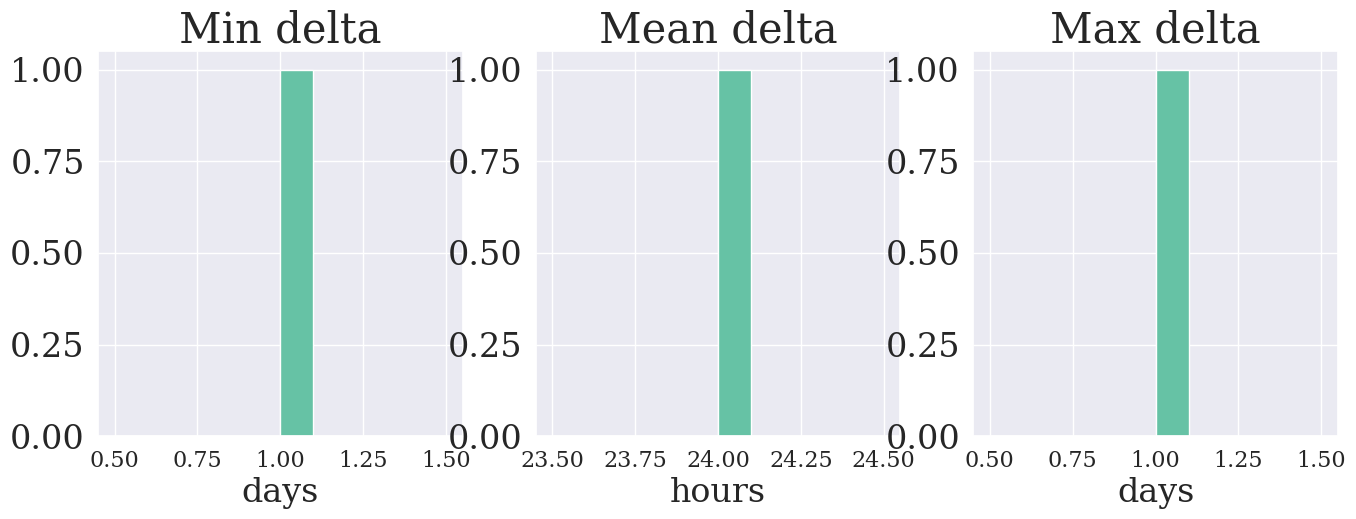

Mean delta info: count     1.0
mean     24.0
std       NaN
min      24.0
25%      24.0
50%      24.0
75%      24.0
max      24.0
dtype: float64
Max delta info: count    1.0
mean     1.0
std      NaN
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
dtype: float64


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(min_arr)
axes[1].hist(mean_arr)
axes[2].hist(max_arr)

axes[0].set_title('Min delta')
axes[1].set_title('Mean delta')
axes[2].set_title('Max delta')

axes[0].set_xlabel('days')
axes[1].set_xlabel('hours')
axes[2].set_xlabel('days')

plt.show()

print('Mean delta info:', pd.Series(mean_arr).describe())
print('Max delta info:', pd.Series(max_arr).describe())


**Вывод**

Видно, что в данных нет пропусков -- записи поступали ежедневно

- Нарисуем данные

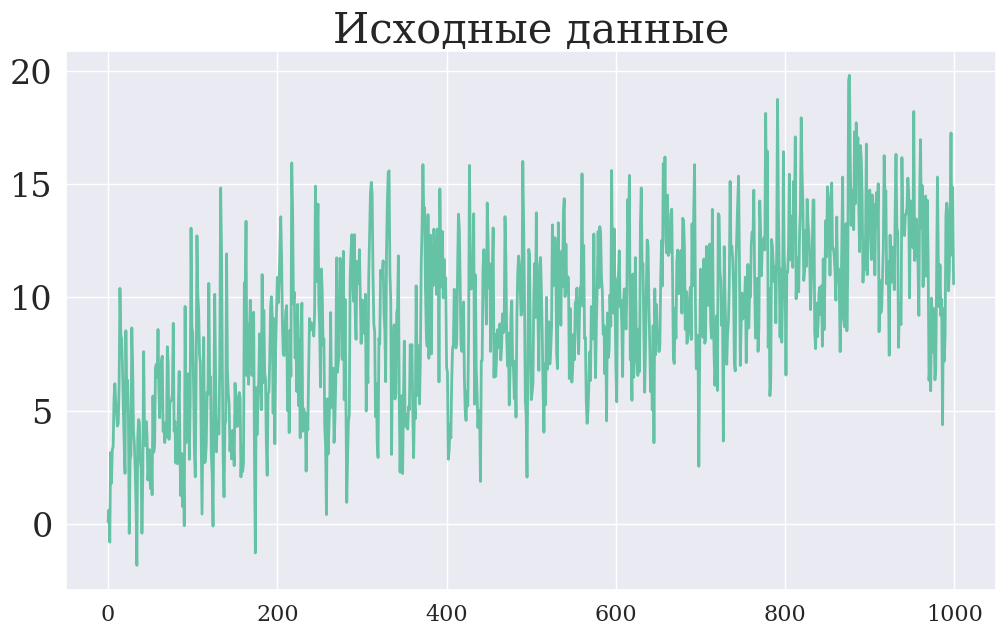

In [8]:
plt.plot(df['y'].values)
plt.title('Исходные данные')
plt.show()

- Можно ли что-то сказать про данные судя по графику?

Виден линейный тренд с несколькими changepoint-ами (примерно на 800 день и на 200 день). Возможно, тренд вообще логистический (судя по первым 800 записям)  

Возможно, присутствуют различные сезонности

- Нарисует `ACF()`, `PACF()`

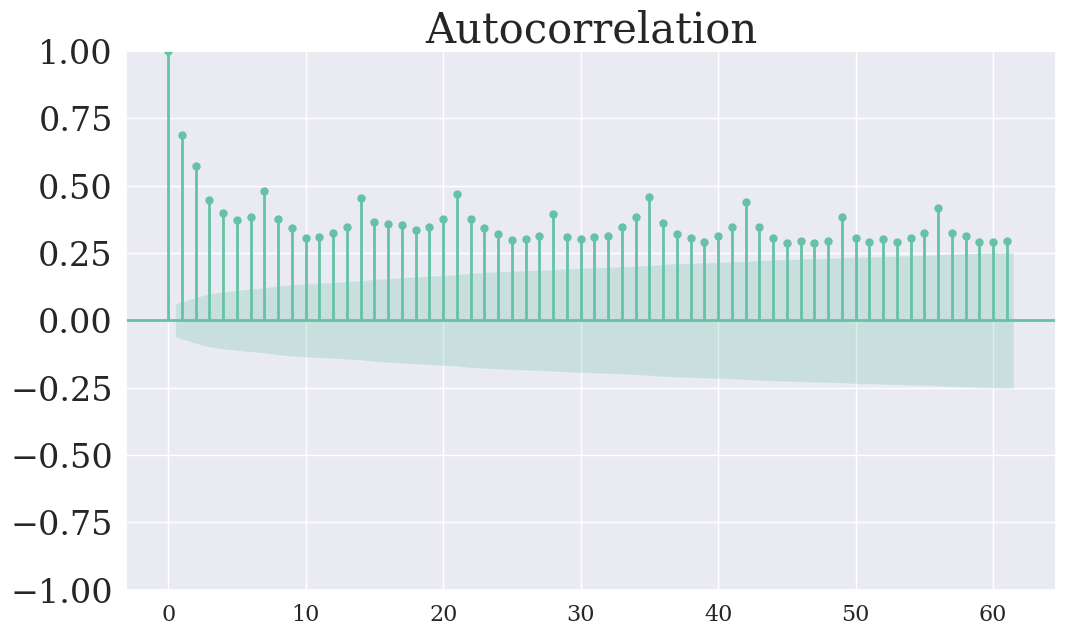

In [9]:
plot_acf(df['y'].values, lags=61);

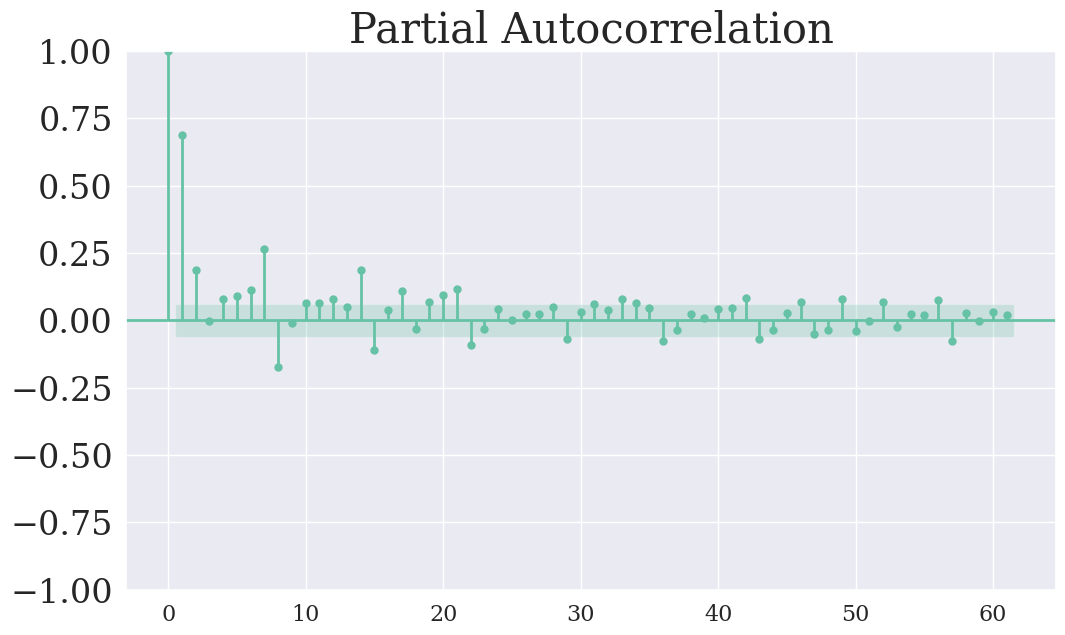

In [10]:
plot_pacf(df['y'].values, lags=61, method='ywm');

- Можно ли сделать какой-то вывод?

1. Есть недельная сезонность.

2. Текущее значение сильно зависит от предыдущего значения

3. Данные, пришедшие > 21 дня назад, слабо влияют на текущее значение

- Ну а теперь ваша свобода 
- Продолжите анализ
    - Не забывайте про стационарность
    - А как насчет тренда?
    - Есть ли сезонность?
    - Может быть в [документации](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) будут еще полезные трюки
    - А может быть будет что-то полезное в [учебнике](https://otexts.com/fpp2/)

### ARIMA

Очевидно, что исходный ВР не стационарен.  
Проверим его на тренд стац-ть и стац-ть в разностях

In [190]:
adf_test(df.y)
print('='*80)
kpss_test(df.y, is_trend=True)

Results of Dickey-Fuller Test:
Test Statistic                  -2.657991
p-value                          0.081594
#Lags Used                      21.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64
Results of KPSS Test:
Test Statistic            4.263181
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




**Вывод:**  
ВР стационарен в разностях и не стационарен отн. линейного тренда

Применим обычное дифф-ние для избавления от тренда

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


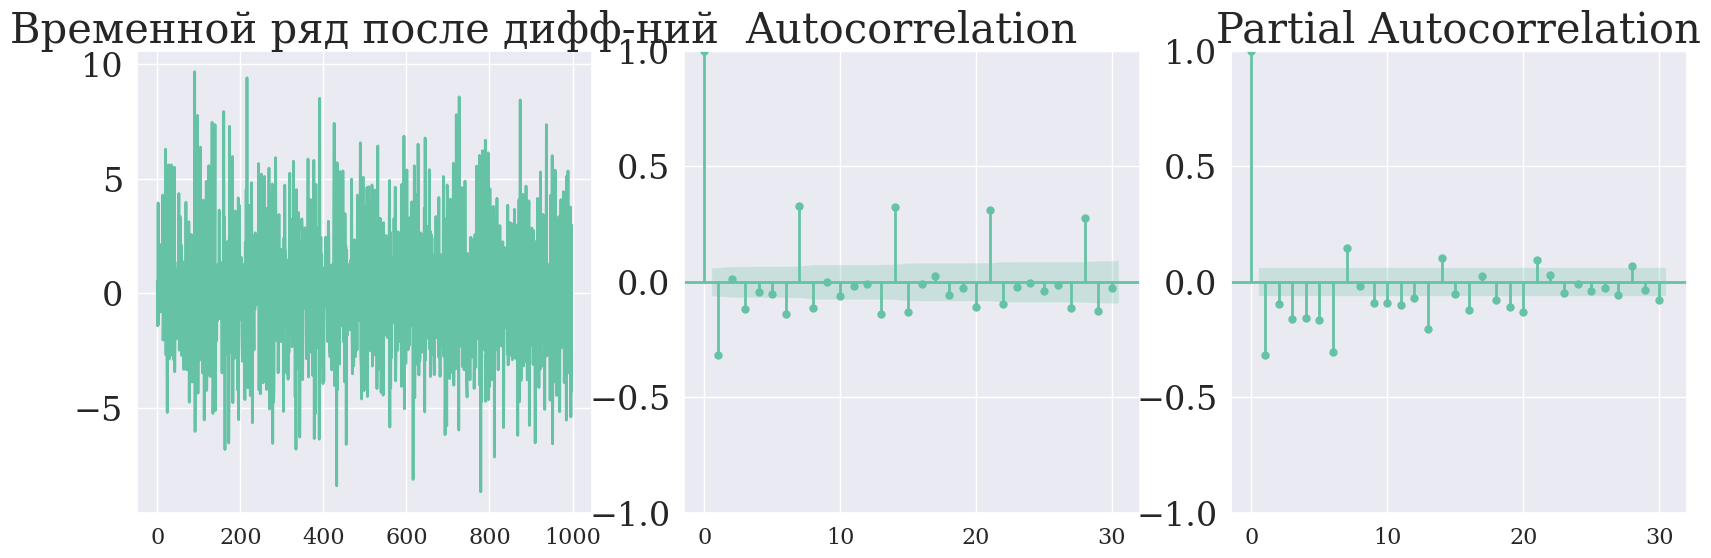

In [53]:
diff_trend_ts = df['y'] - df['y'].shift()
diff_trend_ts.dropna(inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(diff_trend_ts.values)
axes[0].set_title('Временной ряд после дифф-ний')
plot_acf(diff_trend_ts.values, ax=axes[1])
plot_pacf(diff_trend_ts.values, ax=axes[2])

plt.show()

Применим ARMA к полученному временному ряду.  
Ещё раз убедимся в стац-ти продифф. ВР

In [191]:
adf_test(diff_trend_ts)
print('='*80)
kpss_test(diff_trend_ts, is_trend=False)

Results of Dickey-Fuller Test:
Test Statistic                -1.423248e+01
p-value                        1.587762e-26
#Lags Used                     2.600000e+01
Number of Observations Used    1.913000e+03
Critical Value (1%)           -3.433773e+00
Critical Value (5%)           -2.863052e+00
Critical Value (10%)          -2.567575e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.019172
p-value                   0.100000
Lags Used                58.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Воспользуемся следующим эмпирическим правилом:  
В качестве начального приближения для p возьмём последний значимый пик в PACF, для q -- последний значимый пик ACF. Далее по сетке найдём оптим.параметры p и q, минимизирующие BIC.

Возьмём `p_grid, q_grid = range(8)`, чтобы не пришлось долго ждать

In [56]:
p_arr = range(8)
q_arr = range(8)

best_bic = float('inf')
best_model = None

for p in tqdm(p_arr):
    for q in q_arr:
        arma_model = ARIMA(df.y, order=(p, 1, q)).fit()
        
        if arma_model.bic < best_bic:
            best_bic = arma_model.bic
            best_model = arma_model
            
        gc.collect()

  0%|          | 0/8 [00:00<?, ?it/s]

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/eduard/.local/lib/pyt

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/eduard/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/eduard/.local/lib/python3.8/site-packag

In [57]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -2222.412
Date:                Thu, 13 Apr 2023   AIC                           4474.824
Time:                        13:14:53   BIC                           4548.426
Sample:                             0   HQIC                          4502.799
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3273      0.035     -9.313      0.000      -0.396      -0.258
ar.L2         -0.3928      0.033    -11.783      0.000      -0.458      -0.327
ar.L3         -0.3432      0.033    -10.538      0.000      -0.407      -0.279
ar.L4         -0.3736      0.035    -10.696      0.000      -0.442      -0.305
ar.L5         -0.3583      0.031    -11.716      0.000      -0.418      -0.298
ar.L6         -0.3452      0.036     -9.698      0.000      -0.415      -0.275
ar.L7          0.5968      0.030     19.570      0.000       0.537       0.657
ma.L1         -0.1381      0.029     -4.780      0.000      -0.195      -0.081
ma.L2          0.1549      0.029      5.343      0.000       0.098       0.212
ma.L3         -0.0710      0.030     -2.369      0.018      -0.130      -0.012
ma.L4          0.0442      0.032      1.374      0.170      -0.019       0.107
ma.L5         -0.0181      0.032     -0.570      0.568      -0.080       0.044
ma.L6         -0.0201      0.029     -0.683      0.495      -0.078       0.038
ma.L7         -0.8301      0.027    -30.686      0.000      -0.883      -0.777
sigma2         5.0672      0.239     21.222      0.000       4.599       5.535
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.50   Prob(JB):                         0.92
Heteroskedasticity (H):               0.87   Skew:                             0.03
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Видим, что бол-во регрессоров стат.значимо, что не может не радовать

Отрисуем предсказание модели и посмотрим на её остатки

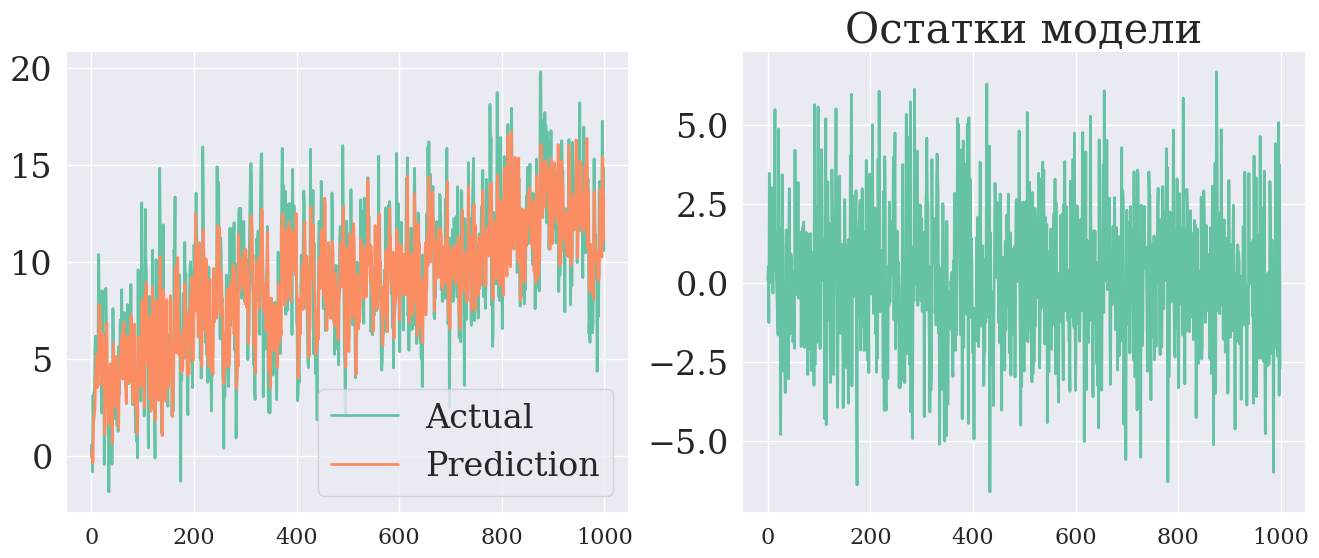

In [63]:
arma_pred = best_model.predict(df.index[0], df.index[-1])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(df.y.values, label='Actual')
axes[0].plot(arma_pred, label='Prediction')
axes[1].plot(best_model.resid)

axes[0].legend()
axes[1].set_title('Остатки модели')
plt.show()

Смотрим на автокорреляцию остатков

In [85]:
acorr_ljungbox(best_model.resid, return_df=True)

lb_stat  lb_pvalue
1    0.428983   0.512489
2    0.924848   0.629755
3    1.339106   0.719869
4    1.732918   0.784730
5    1.870096   0.866812
6    2.481597   0.870522
7    2.521039   0.925504
8    5.983828   0.649043
9    8.013594   0.532777
10  10.147301   0.427667

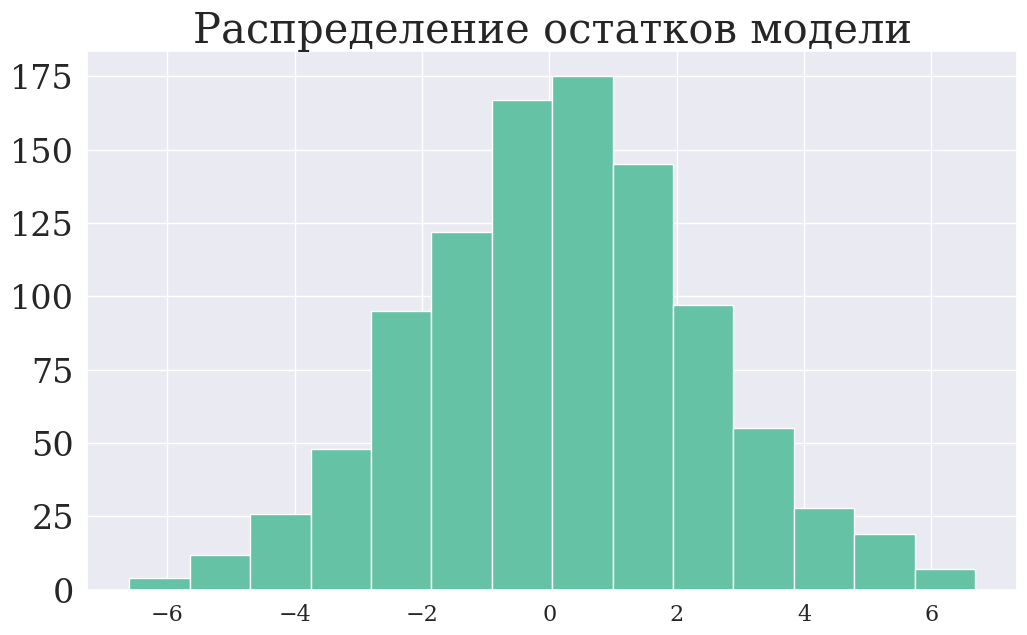

In [67]:
plt.hist(best_model.resid, bins=14)
plt.title('Распределение остатков модели')
plt.show()

Похоже, что остатки модели являются белым шумом

### SARIMA

In [43]:
model2 = pm.auto_arima(
    df.y, #time series
    d=1, # difference order
    D=None, # seasonal difference order
    max_p=2,
    max_q=2,                       
    information_criterion='bic', # used to select best mode
    m=7, # number of periods in each season
    max_P=3,
    max_Q=3,
    max_order=10,
    seasonal=True, # enable sasonal component
    trace=True, # prints the information_criterion for each model it fits
    error_action='ignore', # ignore orders that don't work
    stepwise=True, # apply an intelligent order search
    suppress_warnings=True) 

# Print model summary
print(model2.summary())

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : BIC=inf, Time=6.44 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=4979.919, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=4783.755, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=4795.411, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=4973.025, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=4880.500, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : BIC=4739.528, Time=1.18 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : BIC=4708.295, Time=1.99 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : BIC=inf, Time=10.23 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : BIC=inf, Time=4.23 sec
 ARIMA(0,1,0)(3,0,0)[7] intercept   : BIC=4793.085, Time=1.38 sec
 ARIMA(2,1,0)(3,0,0)[7] intercept   : BIC=4712.235, Time=2.17 sec
 ARIMA(1,1,1)(3,0,0)[7] intercept   : BIC=inf, Time=12.05 sec
 ARIMA(0,1,1)(3,0,0)[7] intercept   : BIC=4694.282, Time=1.44 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : BIC=4725.957,

Графики предсказаний и ошибок

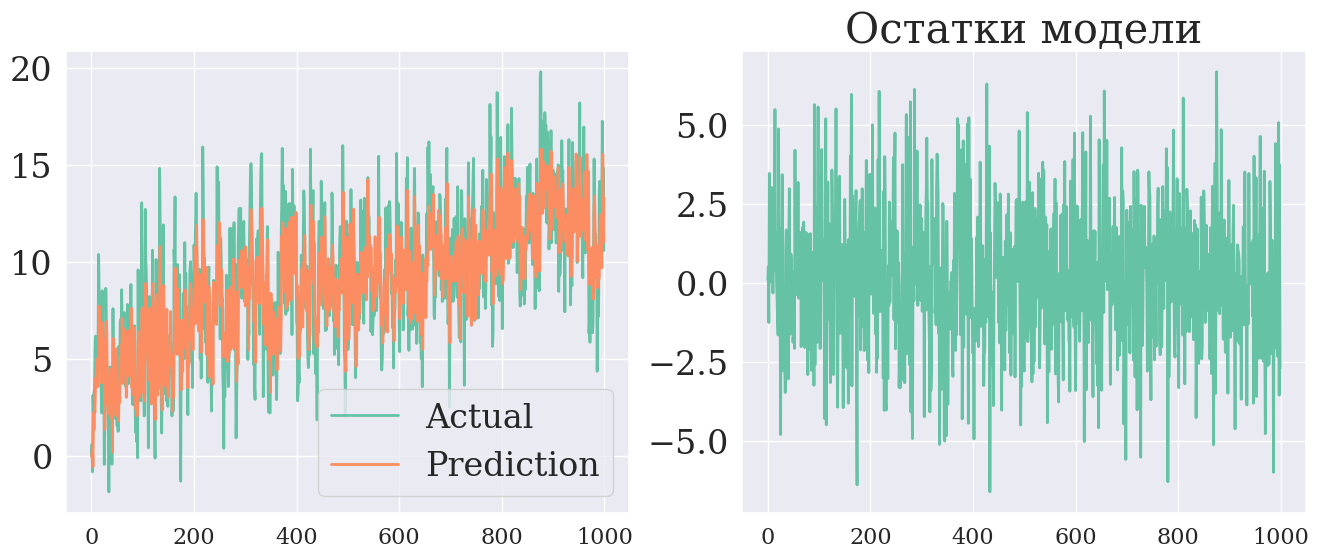

In [116]:
sarima_pred = model2.predict_in_sample()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(df.y.values, label='Actual')
axes[0].plot(sarima_pred, label='Prediction')
axes[1].plot(best_model.resid)

axes[0].legend()
axes[1].set_title('Остатки модели')
plt.show()

Смотрим на автокорреляцию остатков

In [77]:
acorr_ljungbox(model2.resid(), return_df=True)

lb_stat  lb_pvalue
1    4.570123   0.032534
2   22.242036   0.000015
3   24.201525   0.000023
4   24.330145   0.000069
5   26.121899   0.000085
6   26.444140   0.000184
7   26.688859   0.000379
8   26.736690   0.000785
9   26.738965   0.001545
10  30.471867   0.000717

Остатки модели автокоррелируют

### Prophet

Подготовка

In [46]:
df['ds'] = df['date']

Обучение

15:55:38 - cmdstanpy - INFO - Chain [1] start processing
15:55:39 - cmdstanpy - INFO - Chain [1] done processing


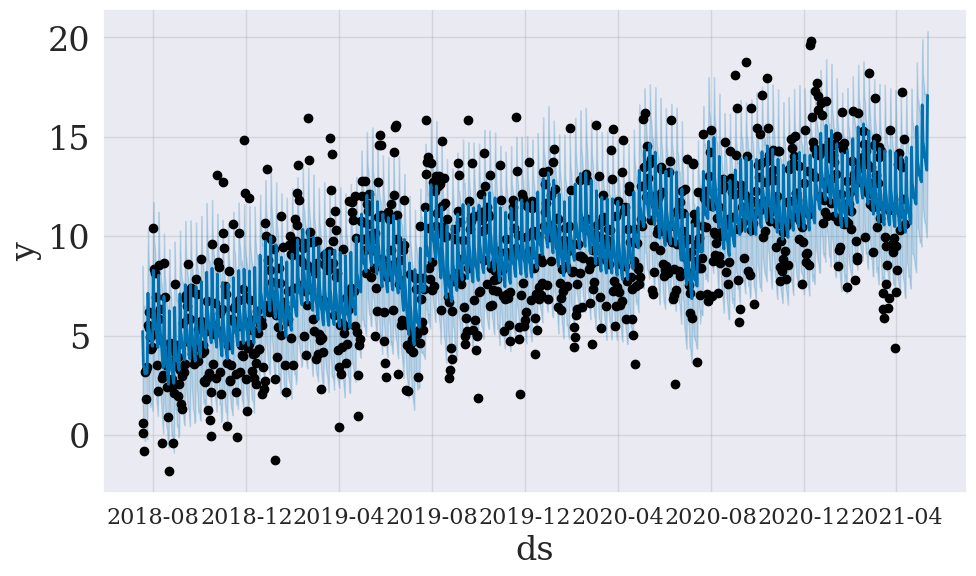

In [100]:
model3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='additive',
)
model3.fit(df)
future = model3.make_future_dataframe(periods=30)
forecast = model3.predict(future)

prophet_prediction = model3.predict()['yhat']

model3.plot(forecast);

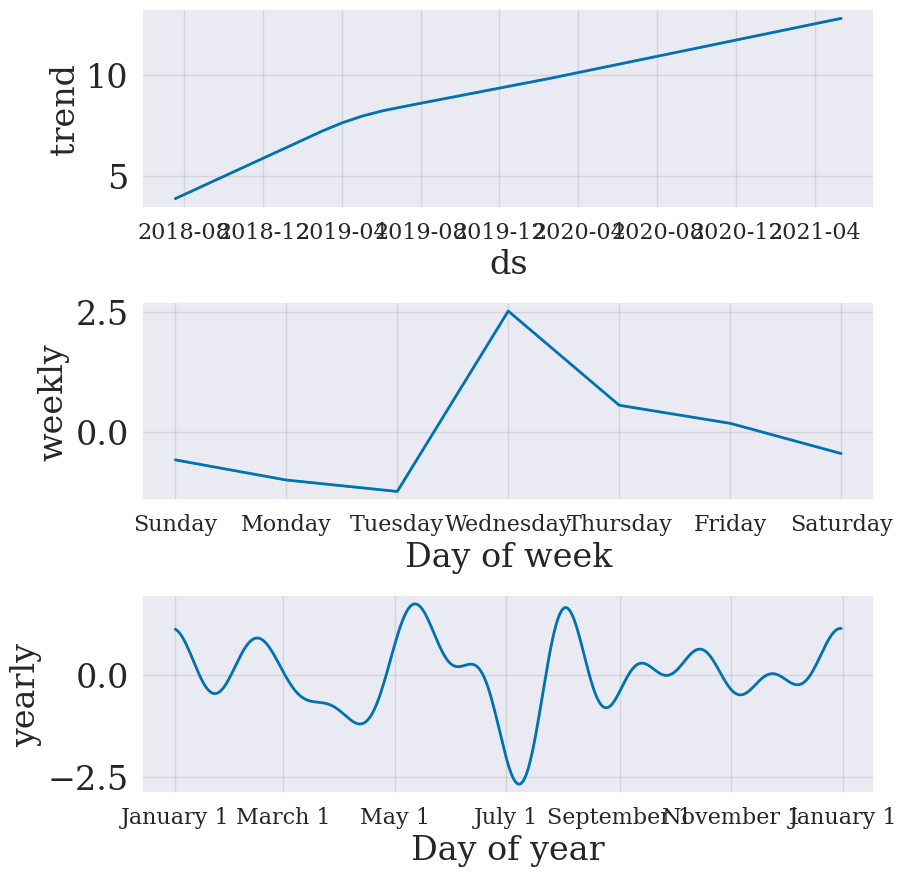

In [99]:
model3.plot_components(forecast);

### Итоговое сравнение моделей

In [171]:
print('ARIMA:', evaluate_prediction(df['y'].values, arma_pred))
print('SARIMA:', evaluate_prediction(df['y'].values, sarima_pred))
print('Prophet:', evaluate_prediction(df['y'].values, prophet_prediction))

ARIMA: {'rmse': 2.235, 'mae': 1.775, 'mase': 0.775, 'smape': 0.243, 'mdape': 0.167}
SARIMA: {'rmse': 2.339, 'mae': 1.85, 'mase': 0.808, 'smape': 0.252, 'mdape': 0.169}
Prophet: {'rmse': 2.524, 'mae': 2.009, 'mase': 0.877, 'smape': 0.26, 'mdape': 0.19}


**Вывод:**

Победила ARIMA!

**Далее будет две задачи. Вам надо выбрать одну. Если вы сделаете и 2.1, и 2.2, то будет выбран минимальный балл из двух**

## №2.1 (60 баллов)

- Не буду расписывать задание (как самый настоящий менеджер)
- На занятии вы разбирали данные о продажах Walmart для прогнозирования ежедневных продаж на следующие 28 дней. С кейсом можно озанкомиться на kaggle: [M5 Forecasting - Uncertainty](https://www.kaggle.com/c/m5-forecasting-uncertainty/overview). Продолжим с ними работать.
- Вам необходимо сделать модель предсказания продаж в штате Висконсин (WI) категории Hobbies в целом (не углубляясь до торговых точек)
- Данные берем [отсюда](https://www.kaggle.com/c/m5-forecasting-uncertainty/data)

In [6]:
PRED_HORIZON = 28

In [7]:
# Помните, что вам нужно выбрать нужные данные (штат Висконсин и категория Хобби)
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')
stv_cols = [c for c in sales_train_evaluation.columns if c not in ['id','item_id','dept_id','store_id']]
sales_train_evaluation = sales_train_evaluation[stv_cols].groupby(['cat_id','state_id'], as_index = False).sum()

# Преобразуем данные в удобный формат
stv_cols_tr = [c for c in stv_cols if c not in ['cat_id','state_id']]
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars = ['cat_id','state_id'], \
                                value_vars = stv_cols_tr)

In [8]:
wiskonsin_condition = sales_train_evaluation['state_id'] == 'WI'
hobbies_condition = sales_train_evaluation['cat_id'] == 'HOBBIES'

data = sales_train_evaluation[wiskonsin_condition & hobbies_condition][['variable', 'value']]
data.sample(5, random_state=SEED)

variable  value
15602   d_1734    795
392       d_44    822
6224     d_692    566
12020   d_1336    701
16214   d_1802    827

In [9]:
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2', \
                     'snap_CA', 'snap_TX', 'snap_WI']]

calendar.sample(5, random_state=SEED)

date       d event_name_1 event_type_1 event_name_2 event_type_2  \
1001  2013-10-26  d_1002          NaN          NaN          NaN          NaN   
1364  2014-10-24  d_1365          NaN          NaN          NaN          NaN   
909   2013-07-26   d_910          NaN          NaN          NaN          NaN   
813   2013-04-21   d_814          NaN          NaN          NaN          NaN   
235   2011-09-21   d_236          NaN          NaN          NaN          NaN   

      snap_CA  snap_TX  snap_WI  
1001        0        0        0  
1364        0        0        0  
909         0        0        0  
813         0        0        0  
235         0        0        0

In [10]:
data = data.merge(calendar[['date', 'd']], how='left', left_on='variable', right_on='d')

In [11]:
data = data.drop(columns=['variable', 'd'])
data.columns = ['y', 'ds']

In [109]:
train_data, test_data = data.iloc[:-PRED_HORIZON], data.iloc[-PRED_HORIZON:]

- Отрисовка данных

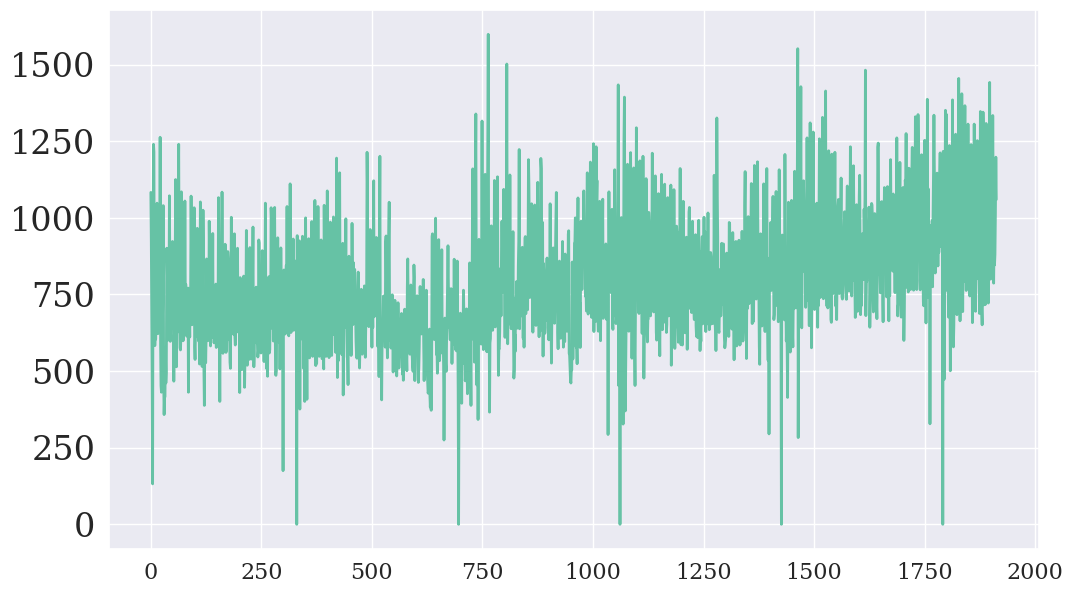

In [25]:
plt.plot(train_data.y.values);

Автокорреляции

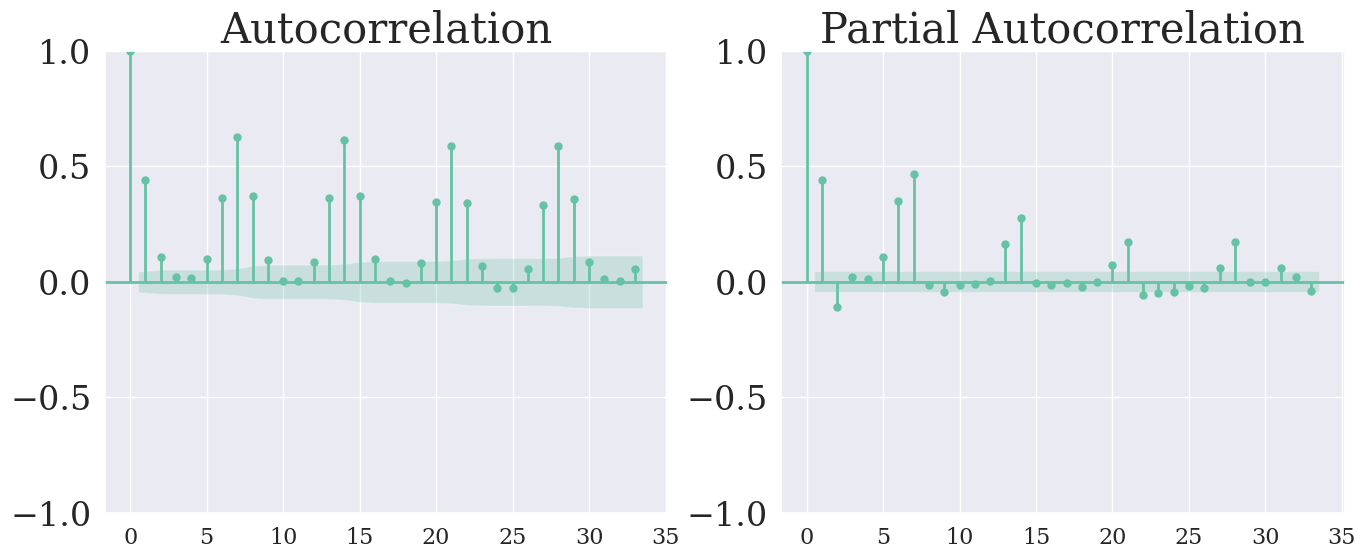

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(train_data.y.values, ax=axes[0])
plot_pacf(train_data.y.values, method='ywm', ax=axes[1])
plt.show()

- Что можете сказать?  

1. На графике прослеживается годовая сезонность  
2. Присутствует недельная сезонность  
3. Направление тренда меняется со временем: наблюдается спад в районе 500 дня и дальнейший подъём

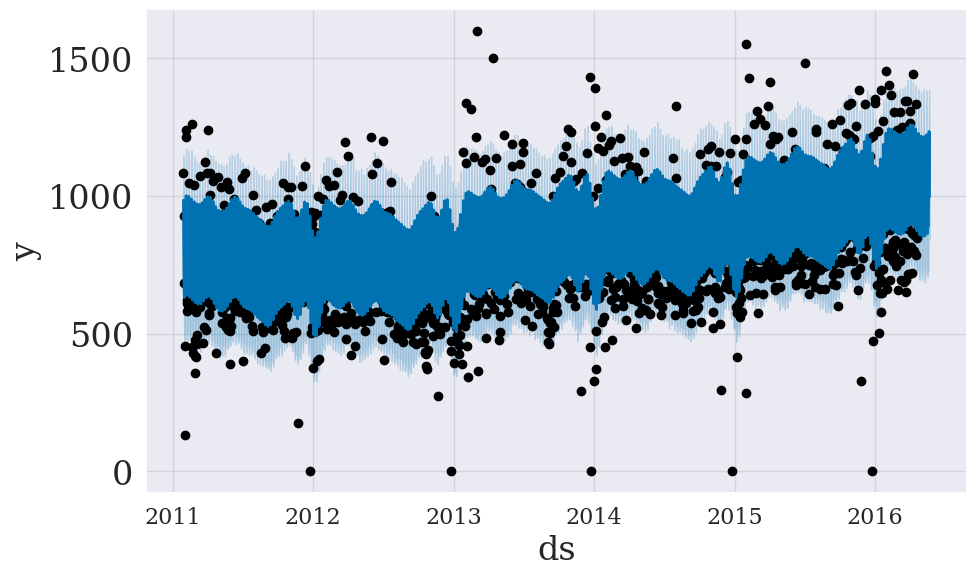

In [111]:
# Попробуйте зафиттить базовую модель
model1 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    seasonality_mode='additive',
)
model1.fit(train_data)
future = model1.make_future_dataframe(periods=PRED_HORIZON)
forecast = model1.predict(future)

prophet_prediction = model1.predict()['yhat']

model1.plot(forecast);

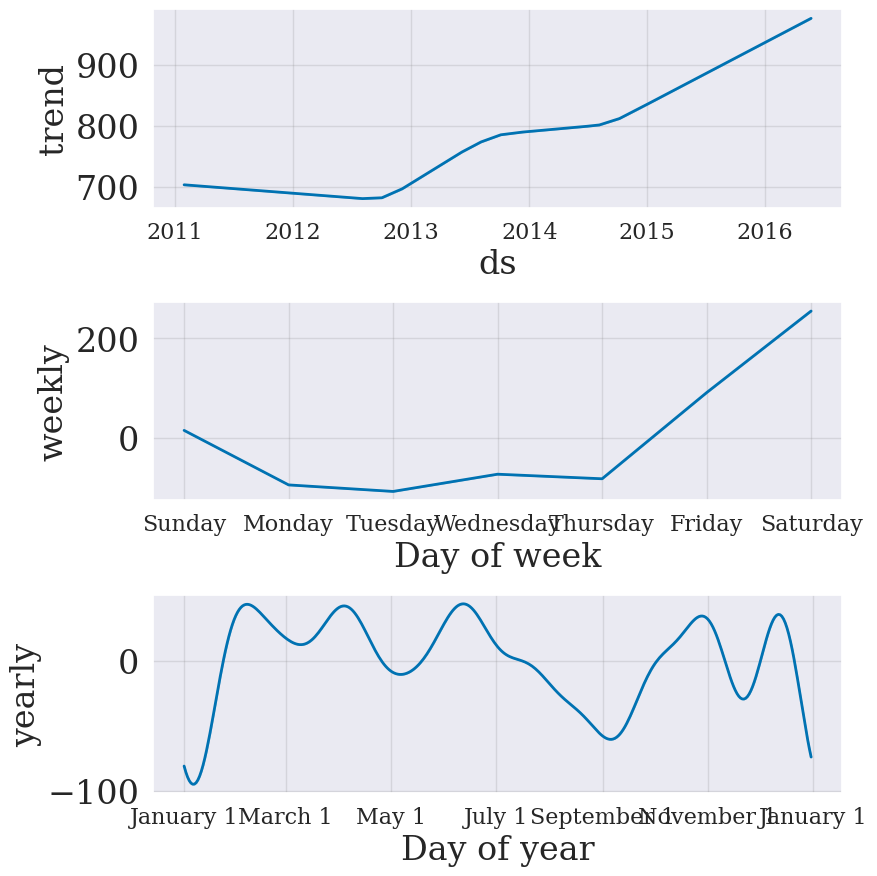

In [28]:
model1.plot_components(forecast);

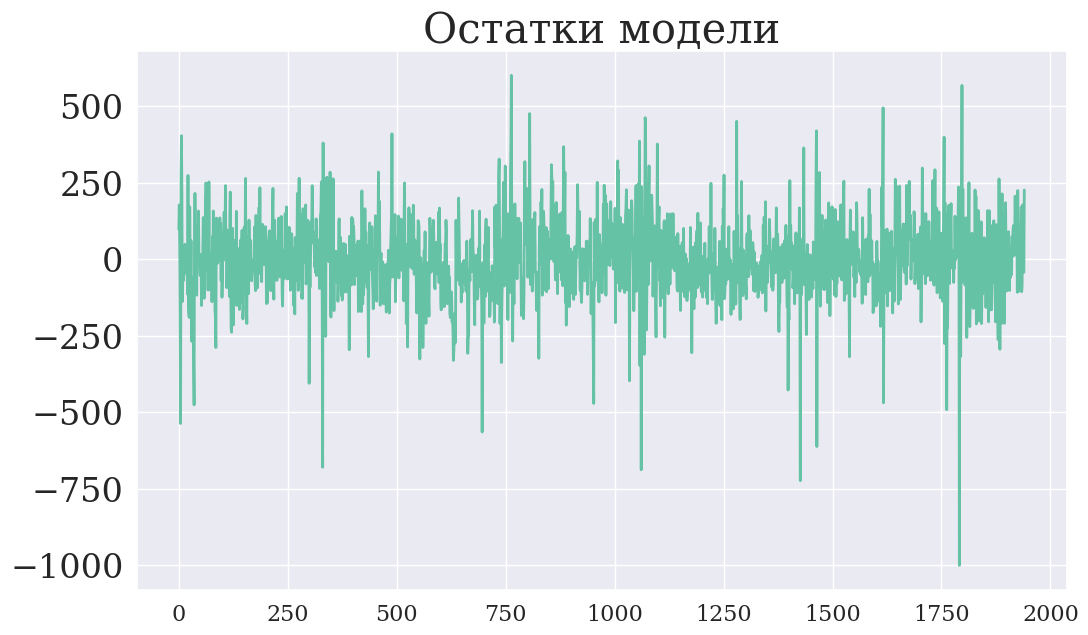

In [29]:
residuals = data['y'] - forecast['yhat']
plt.plot(residuals.values)
plt.title('Остатки модели')
plt.show()

Качество Prophet-a из коробки

In [113]:
evaluate_prediction(train_data.y.values, forecast['yhat'].values[:-PRED_HORIZON])

/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))


{'rmse': 127.011, 'mae': 92.821, 'mase': 0.584, 'smape': 0.125, 'mdape': 0.094}

- Что у вас получилось? 
- Что еще можете сказать, скажем, по поводу компонентов модели?


1. В целом, модель неплохо зафиттилась  
2. Модель пока не справляется с нижними выбросами (которые скорее всего вызваны праздниками)  
3. В выходные люди покупают больше, чем в будние дни  
4. В году есть 5 пиковых моментов с наибольшим размером выручки, их причина пока неизвестна.

- На занятии вам показывали 100500 параметров, с которыми можно поиграться, чтобы получить "лучшую" модель
- Во-первых, начнем с последнего, казалось бы, шага. Какую метрику вы будете использовать? Почему?  
- Каким именно способом вы будете проводить диагностику модели и сравнивать модели?
- Какие параметры вы будете менять? Почему? Попробуйте предположить, как именно необходимо поменять параметр модели, прежде чем приступать к тестированию. За неверное предположение баллы сниматься не будут при наличии обоснования.
- Как еще можно улучшить модель? Что можно добавить еще?

1. Есть нулевые значения (в районе Рождества) ==> MAPE не подойдёт. Решением проблемы служит использование SMAPE. Плюс ко всему, абсолютные значения продаж немаленькие, поэтому никаких проблем с использованием SMAPE не возникнет.  
2. Можно конечно использовать MAE, если нас интересует средняя абсолютная ошибка, но я буду использовать относительную ошибку, поскольку никаких препятствий для этого нет (см п.1).  
3. Сравнивать модели будем по SMAPE.
4. Для диагностики модели используем Diebold-Mariano test, проверку на вложенность.  
5. Добавление месячной сезональности, праздников, модификация типа сезонности для недели и месяца, изменение порядка Фурье для года, недели и месяца.  
6. Можно добавить дополнительные внешние регрессоры, например информацию об акциях (если таковая имеется)

Получение датафрейма праздников

In [31]:
import holidays

us_ca_holidays = holidays.UnitedStates(
    state='WI',
    years=[2011,2012,2013,2014,2015,2016,2017,2018],
    observed=False
)

holiday_df = pd.DataFrame.from_dict(us_ca_holidays, orient='index').reset_index(drop = False)
holiday_df.columns = ['ds', 'holiday']
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df['lower_window'] = -1
holiday_df['upper_window'] = 1
holiday_df = holiday_df[['holiday', 'ds', 'lower_window', 'upper_window']]

# В данных calendar в качестве событий были отмечены Пасха и День отца
# Эти два регулярных события тоже могут отражаться на покупках (следует проверить данный факт отдельно)
# Но сейчас в рамках нашей задачи мы так же вынесем эти дни + Valentine's Day в датафрейм с праздниками
# В эти дни продажи отличаются от аналогичных обычных дней

custom_holidays = pd.DataFrame([{'holiday' : "Father's day", 'ds' : datetime.date(2011,6,19), \
                                 'lower_window':-2, 'upper_window':0},
 {'holiday' : "Father's day", 'ds' : datetime.date(2012,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2013,6,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2014,6,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2015,6,21), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2016,6,19), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2017,6,18), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Father's day", 'ds' : datetime.date(2018,6,17), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2011,4,24), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2012,4,15), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2013,5,5), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2014,4,20), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2015,4,12), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2016,5,1), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2017,4,16), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Easter", 'ds' : datetime.date(2018,4,8), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2011,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2012,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2013,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2014,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2015,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2016,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2017,2,14), 'lower_window':-1, 'upper_window':1},
 {'holiday' : "Valentine's Day", 'ds' : datetime.date(2018,2,14), 'lower_window':-1, 'upper_window':1}])

holiday_df = pd.concat([holiday_df, custom_holidays])
holiday_df = holiday_df.sort_values('ds').reset_index(drop = True)
holiday_df.head()

holiday          ds  lower_window  upper_window
0              New Year's Day  2011-01-01            -1             1
1  Martin Luther King Jr. Day  2011-01-17            -1             1
2             Valentine's Day  2011-02-14            -1             1
3        Susan B. Anthony Day  2011-02-15            -1             1
4       Washington's Birthday  2011-02-21            -1             1

In [32]:
# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [31]:
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').disabled = True

param_grid = {
    'week_mode': ['additive', 'multiplicative'],
    'week_forder': [3, 7, 10],
    'month_mode': ['additive', 'multiplicative'],
    'month_forder': [3, 7, 10],
    'year_forder': [3, 7, 10],
    'holidays_prior_scale': [0.1, 1, 10],
    'seasonality_prior_scale': [0.1, 1, 10]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
cv_results = dict()
smapes = []
maes = []

for params in tqdm(all_params):
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        holidays=holiday_df,
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
    )
    model.add_seasonality(
        name = 'weekly', 
        period = 7,
        fourier_order = params['week_forder'], 
        mode = params['week_mode']
    )
    model.add_seasonality(
        name = 'monthly', 
        period = 30.25,
        fourier_order = params['month_forder'], 
        mode = params['month_mode']
    )
    model.add_seasonality(
        name = 'yearly', 
        period = 365.25,
        fourier_order = params['year_forder'], 
        mode = 'additive'
    )

    with suppress_stdout_stderr():
        model.fit(train_data)

        df_cv = cross_validation(
            model,
            initial='1100 days',
            period='28 days',
            horizon='28 days',
            parallel='processes',
        )

    df_p = performance_metrics(df_cv, metrics=['smape', 'mae'], rolling_window=1)
    smapes.append(df_p['smape'].values[0])
    maes.append(df_p['mae'].values[0])
    
    gc.collect()
    
tuning_results = pd.DataFrame(all_params)
tuning_results['smape'] = smapes
tuning_results['mae'] = maes

  0%|          | 0/972 [00:00<?, ?it/s]

Выводим лучшие параметры

In [34]:
ind = tuning_results['smape'].argmin()
tuning_results.iloc[ind]

week_mode                  multiplicative
week_forder                            10
month_mode                       additive
month_forder                            3
year_forder                             7
holidays_prior_scale                  1.0
seasonality_prior_scale              10.0
smape                            0.109343
mae                             89.472541
Name: 824, dtype: object

Создаём модель с лучшими параметрами и смотрим на то, как она описывает временной ряд

In [33]:
prophet_model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    holidays=holiday_df,
    holidays_prior_scale=1.0,
    seasonality_prior_scale=10.0,
)
prophet_model.add_seasonality(
    name = 'weekly', 
    period = 7,
    fourier_order = 10, 
    mode = 'multiplicative'
)
prophet_model.add_seasonality(
    name = 'monthly', 
    period = 30.25,
    fourier_order = 3, 
    mode = 'additive'
)
prophet_model.add_seasonality(
    name = 'yearly', 
    period = 365.25,
    fourier_order = 7, 
    mode = 'additive'
)
prophet_model.fit(train_data)

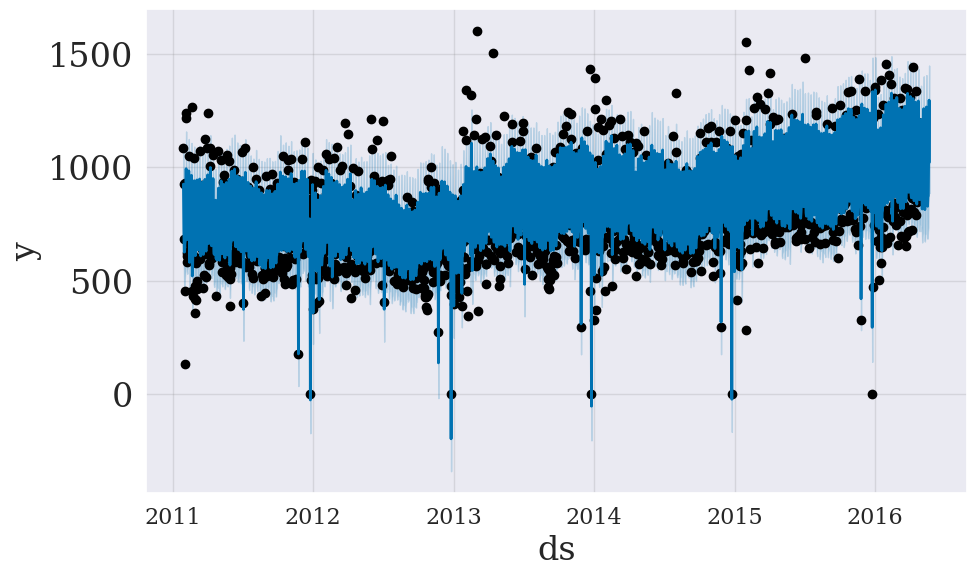

In [34]:
future = prophet_model.make_future_dataframe(periods=PRED_HORIZON)
forecast = prophet_model.predict(future)

prophet_prediction = prophet_model.predict()['yhat']

prophet_model.plot(forecast);

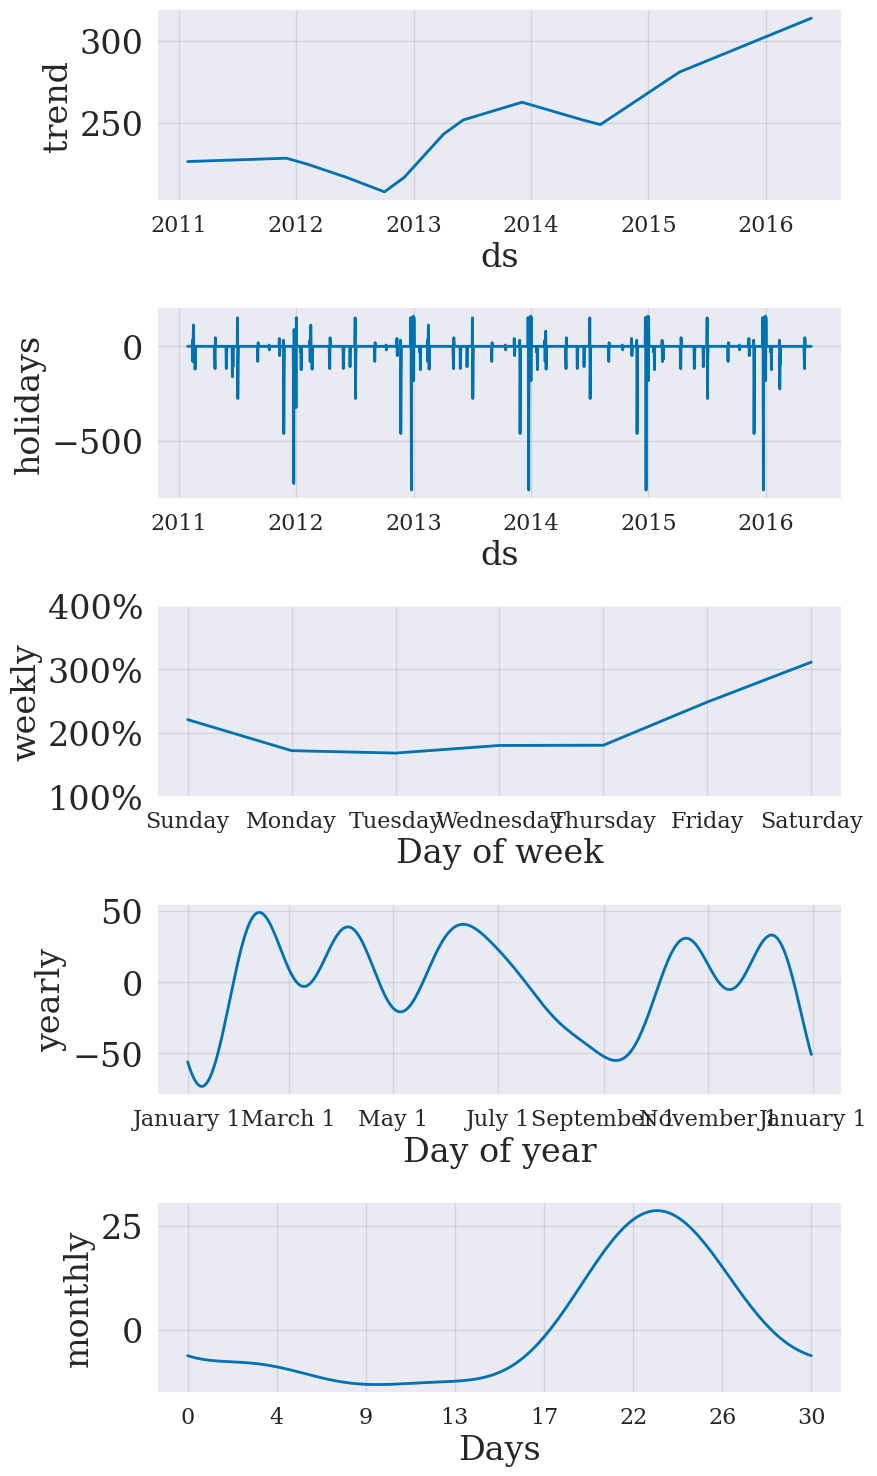

In [35]:
prophet_model.plot_components(forecast);

- А что если попробовать воспользоваться моделями другого класса? Давайте воспользуемся моделями класса [SARIMAX](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html). Это обобщение класса SARIMA. Исопльзование внешних регрессоров не обязательно.
- Является временной ряд, с которым вы работаете стационарным? Тренд стационарым? Стационарным в разностях?
- Сколько лагов стоит использовать?

In [38]:
adf_test(train_data['y'])
print('='*80)
kpss_test(train_data['y'], is_trend=True)

Results of Dickey-Fuller Test:
Test Statistic                   -3.021206
p-value                           0.032961
#Lags Used                       26.000000
Number of Observations Used    1886.000000
Critical Value (1%)              -3.433822
Critical Value (5%)              -2.863074
Critical Value (10%)             -2.567586
dtype: float64
Results of KPSS Test:
Test Statistic            8.153917
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Исходный ВР, очевидно, не является стационарным.  
KPSS показывает, что ВР не является тренд-стационарным.  
Дики-Фуллер говорит о стац-ти в разностях (и то еле-еле)

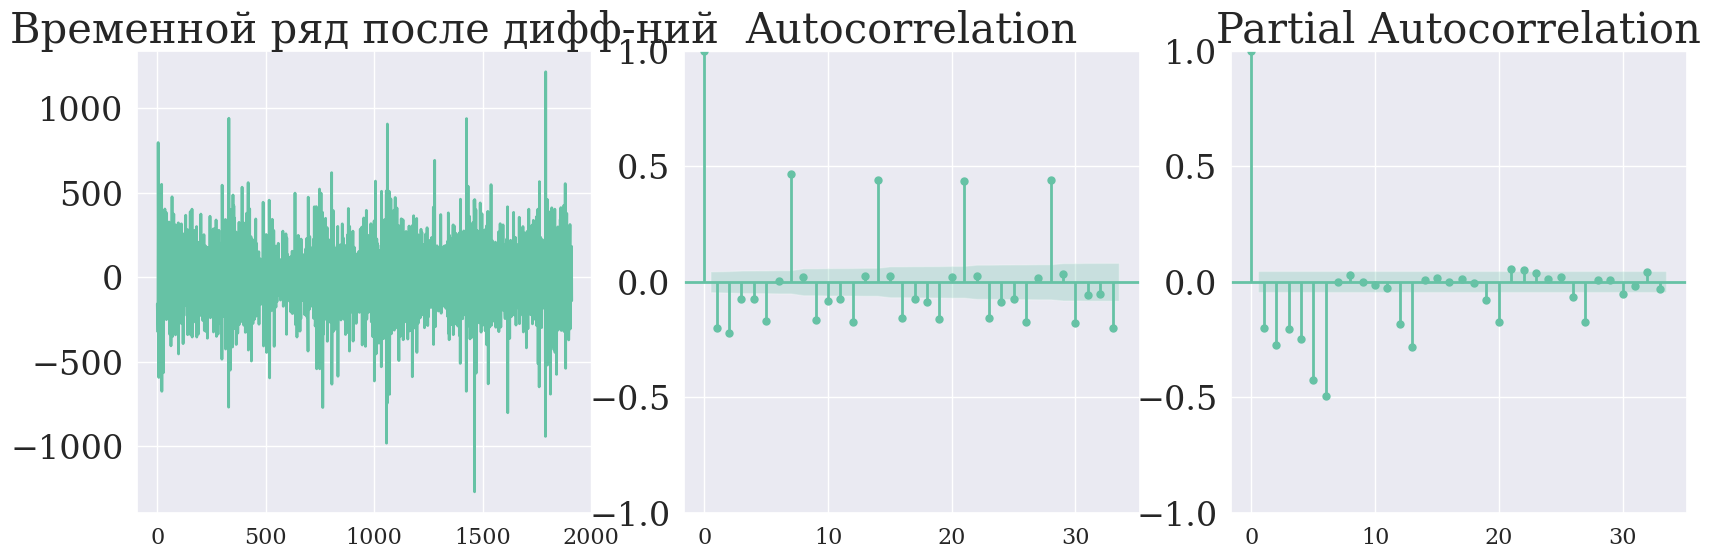

In [39]:
diff_trend_ts = train_data['y'] - train_data['y'].shift()
diff_trend_ts.dropna(inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(diff_trend_ts.values)
axes[0].set_title('Временной ряд после дифф-ний')
plot_acf(diff_trend_ts.values, ax=axes[1])
plot_pacf(diff_trend_ts.values, method='ywm', ax=axes[2])

plt.show()

In [40]:
adf_test(diff_trend_ts)
print('='*80)
kpss_test(diff_trend_ts, is_trend=False)

Results of Dickey-Fuller Test:
Test Statistic                -1.407652e+01
p-value                        2.878376e-26
#Lags Used                     2.600000e+01
Number of Observations Used    1.885000e+03
Critical Value (1%)           -3.433824e+00
Critical Value (5%)           -2.863075e+00
Critical Value (10%)          -2.567587e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.018862
p-value                   0.100000
Lags Used                58.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Дики-Фуллер и KPSS говорят нам о стац-ти в разностях  
Попробуем избавиться от автокорреляции добавлением сезонного дифф-ния

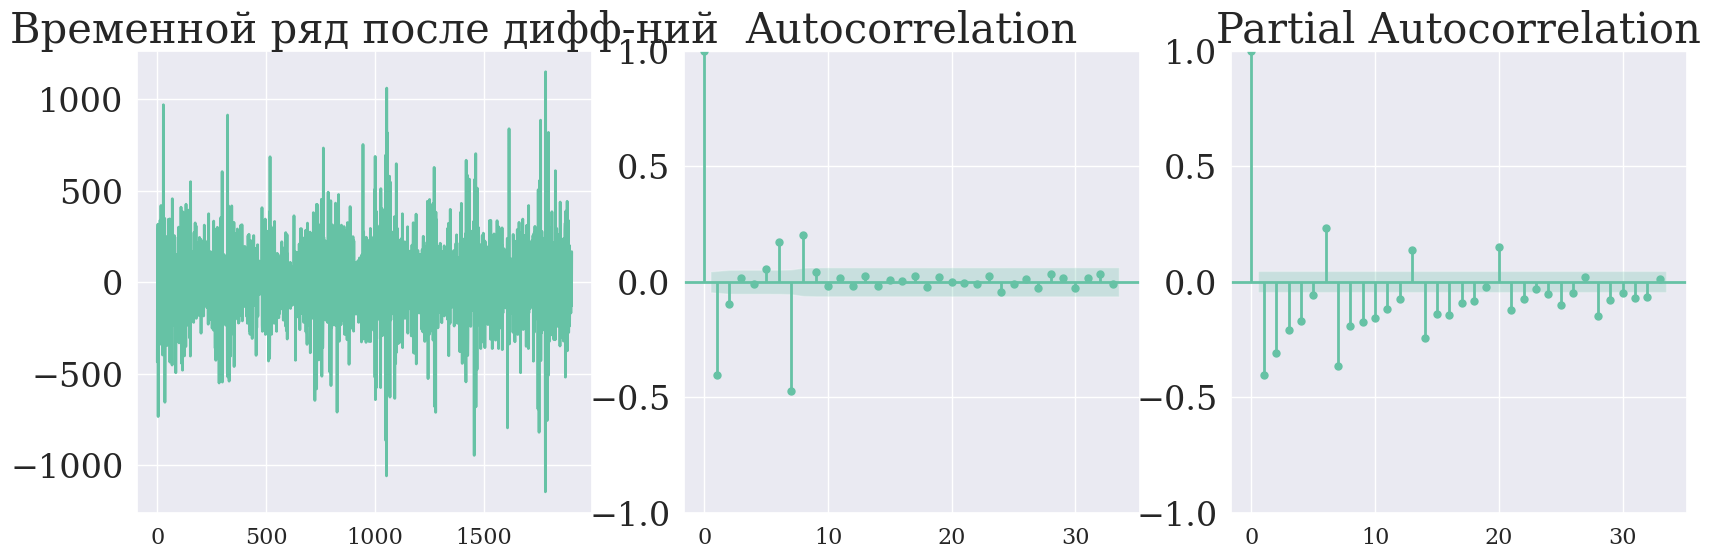

In [41]:
diff_season_ts = diff_trend_ts - diff_trend_ts.shift(7)
diff_season_ts.dropna(inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(diff_season_ts.values)
axes[0].set_title('Временной ряд после дифф-ний')
plot_acf(diff_season_ts.values, ax=axes[1])
plot_pacf(diff_season_ts.values, method='ywm', ax=axes[2])

plt.show()

Всё ушло в частичную автокорреляцию(((

Найдём оптимальные параметры p и q для ARIMA(*, 1, *) поиском по сетке

### ARIMA

In [205]:
p_arr = range(8)
q_arr = range(8)

best_bic = float('inf')
best_model = None

for p in tqdm(p_arr):
    for q in q_arr:
        arma_model = ARIMA(train_data.y, order=(p, 1, q)).fit()
        
        if arma_model.bic < best_bic:
            best_bic = arma_model.bic
            best_model = arma_model
            
        gc.collect()

  0%|          | 0/8 [00:00<?, ?it/s]

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/eduard/.local/lib/python3.8/site-packages/stats

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/eduard/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [43]:
arima_model = best_model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1913
Model:                 ARIMA(7, 1, 7)   Log Likelihood              -12031.998
Date:                Fri, 14 Apr 2023   AIC                          24093.996
Time:                        19:31:43   BIC                          24177.334
Sample:                             0   HQIC                         24124.666
                               - 1913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7259      0.057    -12.708      0.000      -0.838      -0.614
ar.L2         -0.7631      0.033    -23.152      0.000      -0.828      -0.698
ar.L3         -0.7657      0.046    -16.503      0.000      -0.857      -0.675
ar.L4         -0.7446      0.043    -17.233      0.000      -0.829      -0.660
ar.L5         -0.7960      0.039    -20.431      0.000      -0.872      -0.720
ar.L6         -0.6906      0.052    -13.306      0.000      -0.792      -0.589
ar.L7          0.1715      0.025      6.770      0.000       0.122       0.221
ma.L1         -0.0852      0.059     -1.455      0.146      -0.200       0.030
ma.L2          0.0475      0.044      1.069      0.285      -0.040       0.135
ma.L3          0.0690      0.042      1.627      0.104      -0.014       0.152
ma.L4          0.0217      0.042      0.515      0.607      -0.061       0.104
ma.L5          0.0752      0.043      1.765      0.078      -0.008       0.159
ma.L6         -0.1398      0.042     -3.346      0.001      -0.222      -0.058
ma.L7         -0.6951      0.048    -14.600      0.000      -0.788      -0.602
sigma2      1.818e+04    361.282     50.319      0.000    1.75e+04    1.89e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):              2628.94
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.53
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Остатки модели гетероскедастичны, распр-ие остатков далеко от нормального, 3-6 MA-лаги незначимы.  
Зато нет проблем с автокорреляцией

Отрисуем полученные предсказания

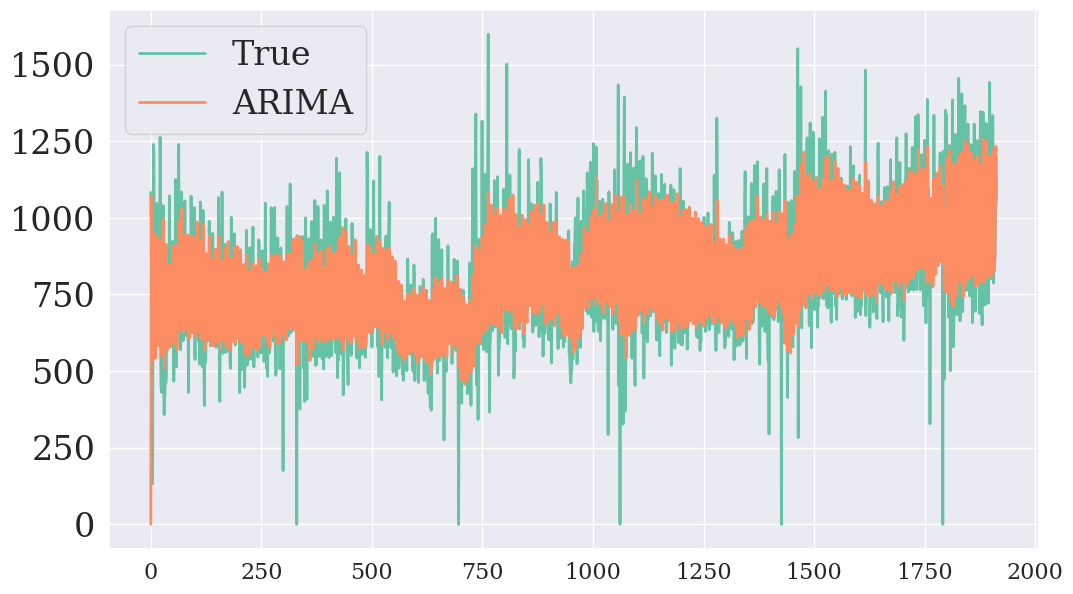

In [44]:
plt.plot(train_data.y.values, label='True')
plt.plot(arima_model.predict().values, label='ARIMA')
plt.legend()
plt.show()

ARIMA неплохо описывает временной ряд, но пока не справляется с рождественными просадками и февральскими пиками

### SARIMA

In [17]:
sarima_model = pm.auto_arima(
    train_data.y, #time series
    d=1, # difference order
    D=1, # seasonal difference order
    max_p=2,
    max_q=2,                       
    information_criterion='bic', # used to select best mode
    m=7, # number of periods in each season
    max_P=4,
    max_Q=4,
    max_order=12,
    seasonal=True, # enable sasonal component
    trace=True, # prints the information_criterion for each model it fits
    error_action='ignore', # ignore orders that don't work
    stepwise=True, # apply an intelligent order search
    suppress_warnings=True) 

# Print model summary
print(sarima_model.summary())

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[7]             : BIC=inf, Time=5.28 sec
 ARIMA(0,1,0)(0,1,0)[7]             : BIC=26294.939, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : BIC=25459.008, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[7]             : BIC=inf, Time=1.64 sec
 ARIMA(1,1,0)(0,1,0)[7]             : BIC=25958.428, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : BIC=25262.885, Time=1.33 sec
 ARIMA(1,1,0)(3,1,0)[7]             : BIC=25138.956, Time=2.22 sec
 ARIMA(1,1,0)(4,1,0)[7]             : BIC=25102.906, Time=3.96 sec
 ARIMA(1,1,0)(4,1,1)[7]             : BIC=inf, Time=19.20 sec
 ARIMA(1,1,0)(3,1,1)[7]             : BIC=inf, Time=12.44 sec
 ARIMA(0,1,0)(4,1,0)[7]             : BIC=25452.405, Time=1.20 sec
 ARIMA(2,1,0)(4,1,0)[7]             : BIC=24925.397, Time=4.88 sec
 ARIMA(2,1,0)(3,1,0)[7]             : BIC=24949.870, Time=3.30 sec
 ARIMA(2,1,0)(4,1,1)[7]             : BIC=inf, Time=25.04 sec
 ARIMA(2,1,0)(3,1,1)[7]             : BIC=inf,

Остатки по-прежнему имеют не нормальнон распределение, в остатках модели присутствует автокорреляция. BIC на 500 больше, чем у ARIMA.  
Зато все коэфф-ты стат.значимы, и pvalue на гетероскедастичность увеличилось

In [50]:
sarima_model = SARIMAX(
    endog=train_data.y,
    order=(2, 1, 0),
    seasonal_order=(4, 1, 0, 7)
)
sarima_results = sarima_model.fit(disp=False)

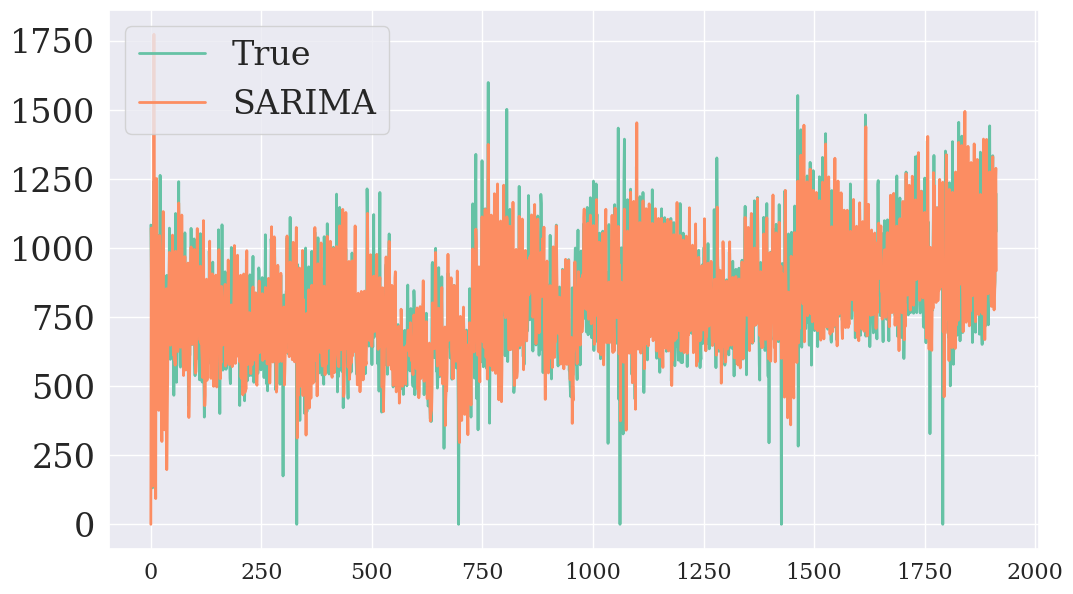

In [51]:
plt.plot(train_data.y.values, label='True')
plt.plot(sarima_results.predict().values, label='SARIMA')
plt.legend()
plt.show()

SARIMA хорошо описывает временной ряд, улавливает февральские пики, но пока не справляется с рождественскими просадками. Для решения последней проблемы добавим экзогенных переменных в нашу модель, а именно праздничные даты

### SARIMAX

Возьмём SARIMA(2, 1, 0)x(4, 1, 0, 7) + праздничные даты

In [52]:
data['ds'] = pd.to_datetime(data['ds'])
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

sarimax_holidays = pd.DataFrame()
sarimax_holidays['ds'] = data['ds']
sarimax_holidays['holiday'] = ['X'] * len(data)

for idx, row in holiday_df.iterrows():
    holiday_start = row['ds'] + pd.to_timedelta(row['lower_window'], 'days')
    holiday_end = row['ds'] + pd.to_timedelta(row['upper_window'], 'days')
    
    sarimax_holidays.loc[
        (sarimax_holidays['ds'] >= holiday_start) & 
        (sarimax_holidays['ds'] <= holiday_end), 'holiday'
    ] = row['holiday']
    
sarimax_holidays = pd.get_dummies(sarimax_holidays)
sarimax_holidays.drop(columns='holiday_X', inplace=True)

In [53]:
sarimax_holidays.head()

ds  holiday_Christmas Day  holiday_Christmas Eve  \
0 2011-01-29                      0                      0   
1 2011-01-30                      0                      0   
2 2011-01-31                      0                      0   
3 2011-02-01                      0                      0   
4 2011-02-02                      0                      0   

   holiday_Columbus Day  holiday_Easter  holiday_Father's day  \
0                     0               0                     0   
1                     0               0                     0   
2                     0               0                     0   
3                     0               0                     0   
4                     0               0                     0   

   holiday_Independence Day  holiday_Labor Day  \
0                         0                  0   
1                         0                  0   
2                         0                  0   
3                         0                  0   
4                         0                  0   

   holiday_Martin Luther King Jr. Day  holiday_Memorial Day  \
0                                   0                     0   
1                                   0                     0   
2                                   0                     0   
3                                   0                     0   
4                                   0                     0   

   holiday_New Year's Day  holiday_New Year's Eve  \
0                       0                       0   
1                       0                       0   
2                       0                       0   
3                       0                       0   
4                       0                       0   

   holiday_Susan B. Anthony Day  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   holiday_Susan B. Anthony Day; Washington's Birthday  holiday_Thanksgiving  \
0                                                  0                       0   
1                                                  0                       0   
2                                                  0                       0   
3                                                  0                       0   
4                                                  0                       0   

   holiday_Valentine's Day  holiday_Veterans Day  \
0                        0                     0   
1                        0                     0   
2                        0                     0   
3                        0                     0   
4                        0                     0   

   holiday_Washington's Birthday  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0

Обучаем модель

In [57]:
sarimax_model = SARIMAX(
    endog=train_data.y,
    exog=sarimax_holidays.iloc[:len(train_data), 1:].values,
    order=(2, 1, 0),
    seasonal_order=(4, 1, 0, 7)
)
sarimax_res = sarimax_model.fit(disp=False)

Смотрим на summary и на графики

In [58]:
sarimax_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1913
Model:             SARIMAX(2, 1, 0)x(4, 1, 0, 7)   Log Likelihood              -12225.058
Date:                           Fri, 14 Apr 2023   AIC                          24498.116
Time:                                   19:41:23   BIC                          24631.370
Sample:                                        0   HQIC                         24547.164
                                          - 1913                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -217.1049     29.602     -7.334      0.000    -275.124    -159.086
x2            83.7501     53.257      1.573      0.116     -20.632     188.132
x3            -9.1271     45.872     -0.199      0.842     -99.034      80.780
x4           -39.7480     36.871     -1.078      0.281    -112.013      32.517
x5           -56.6381     40.510     -1.398      0.162    -136.037      22.761
x6           -65.1174     24.881     -2.617      0.009    -113.883     -16.352
x7           -16.8358     52.036     -0.324      0.746    -118.824      85.152
x8           -73.0126     30.280     -2.411      0.016    -132.360     -13.665
x9           -64.6214     41.404     -1.561      0.119    -145.773      16.530
x10           61.7931     24.962      2.475      0.013      12.868     110.718
x11          -10.6342     54.388     -0.196      0.845    -117.232      95.963
x12          -30.2077     34.539     -0.875      0.382     -97.903      37.488
x13          -16.4162    100.542     -0.163      0.870    -213.476     180.643
x14         -147.1565     23.950     -6.144      0.000    -194.099    -100.214
x15            6.0098     57.398      0.105      0.917    -106.489     118.509
x16           12.1432     48.230      0.252      0.801     -82.386     106.672
x17          -41.1199     30.447     -1.351      0.177    -100.794      18.554
ar.L1         -0.5908      0.015    -38.994      0.000      -0.620      -0.561
ar.L2         -0.3052      0.020    -15.628      0.000      -0.343      -0.267
ar.S.L7       -0.7590      0.022    -34.818      0.000      -0.802      -0.716
ar.S.L14      -0.5605      0.025    -22.689      0.000      -0.609      -0.512
ar.S.L21      -0.3473      0.024    -14.553      0.000      -0.394      -0.301
ar.S.L28      -0.1425      0.020     -7.099      0.000      -0.182      -0.103
sigma2       2.19e+04    490.868     44.619      0.000    2.09e+04    2.29e+04
===================================================================================
Ljung-Box (L1) (Q):                   9.91   Jarque-Bera (JB):              1171.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.20
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Большинство праздников не влияют на число продаж.

Выведем только значимые праздники и обучимся ещё раз ТОЛЬКО с этими праздниками

In [60]:
holiday_names = sarimax_holidays.columns[1:].values
significant_holidays_ind = np.flatnonzero((sarimax_res.pvalues < 0.05).values)
significant_holidays_ind = significant_holidays_ind[
    significant_holidays_ind < len(holiday_names)
]

print('Значимые праздники:')
print(holiday_names[significant_holidays_ind])

Значимые праздники:
['holiday_Christmas Day' 'holiday_Independence Day'
 'holiday_Martin Luther King Jr. Day' "holiday_New Year's Day"
 'holiday_Thanksgiving']


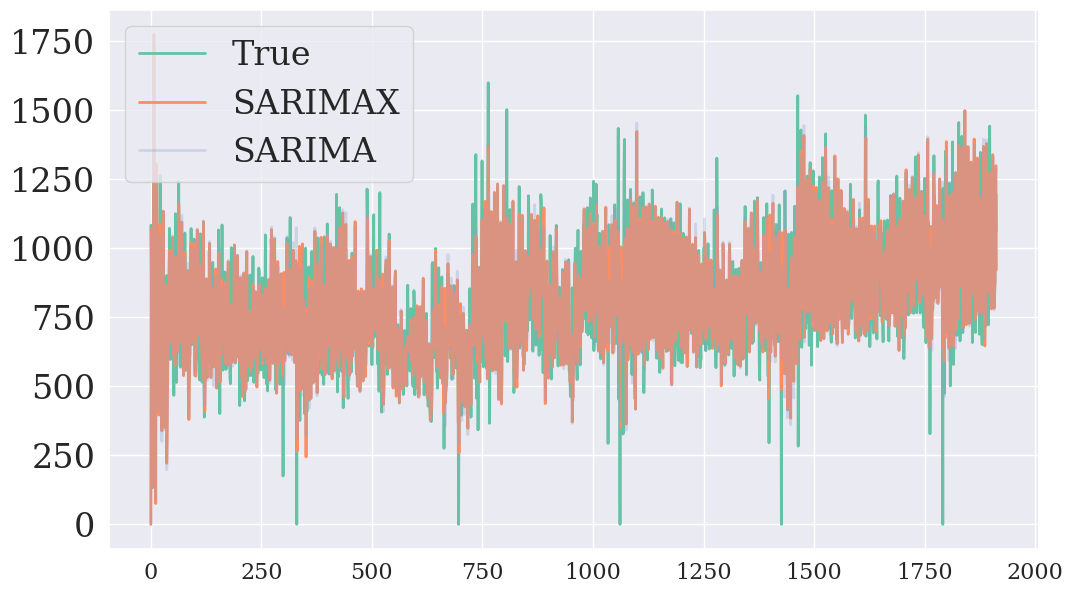

In [61]:
plt.plot(train_data.y.values, label='True')
plt.plot(sarimax_res.predict().values, label='SARIMAX')
plt.plot(sarima_results.predict().values, label='SARIMA', alpha=0.3)

plt.legend()
plt.show()

Визуально, предсказания SARIMA и SARIMAX практически не отличаются

Повторное обучение

In [62]:
params_to_choose = sarimax_res.params.values
start_params = list(params_to_choose[significant_holidays_ind]) + list(params_to_choose[len(holiday_names):])

sarimax2_model = SARIMAX(
    endog=train_data.y,
    exog=sarimax_holidays.iloc[:len(train_data), significant_holidays_ind+1].values,
    order=(2, 1, 0),
    seasonal_order=(4, 1, 0, 7),
    start_params=start_params
)
sarimax2_res = sarimax2_model.fit(disp=False)

Ещё раз взглянем на summary и на графики предсказаний

In [63]:
sarimax2_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1913
Model:             SARIMAX(2, 1, 0)x(4, 1, 0, 7)   Log Likelihood              -12231.774
Date:                           Fri, 14 Apr 2023   AIC                          24487.549
Time:                                   19:44:00   BIC                          24554.176
Sample:                                        0   HQIC                         24512.073
                                          - 1913                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -218.9235     23.266     -9.410      0.000    -264.524    -173.323
x2           -65.6720     25.369     -2.589      0.010    -115.394     -15.950
x3           -73.6872     30.419     -2.422      0.015    -133.308     -14.067
x4            62.2637     23.070      2.699      0.007      17.048     107.479
x5          -148.4293     24.024     -6.178      0.000    -195.516    -101.342
ar.L1         -0.5855      0.015    -39.085      0.000      -0.615      -0.556
ar.L2         -0.3090      0.019    -16.218      0.000      -0.346      -0.272
ar.S.L7       -0.7587      0.022    -35.017      0.000      -0.801      -0.716
ar.S.L14      -0.5607      0.024    -23.178      0.000      -0.608      -0.513
ar.S.L21      -0.3467      0.024    -14.672      0.000      -0.393      -0.300
ar.S.L28      -0.1424      0.020     -7.172      0.000      -0.181      -0.103
sigma2      2.206e+04    486.410     45.346      0.000    2.11e+04     2.3e+04
===================================================================================
Ljung-Box (L1) (Q):                   9.99   Jarque-Bera (JB):              1242.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.21
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

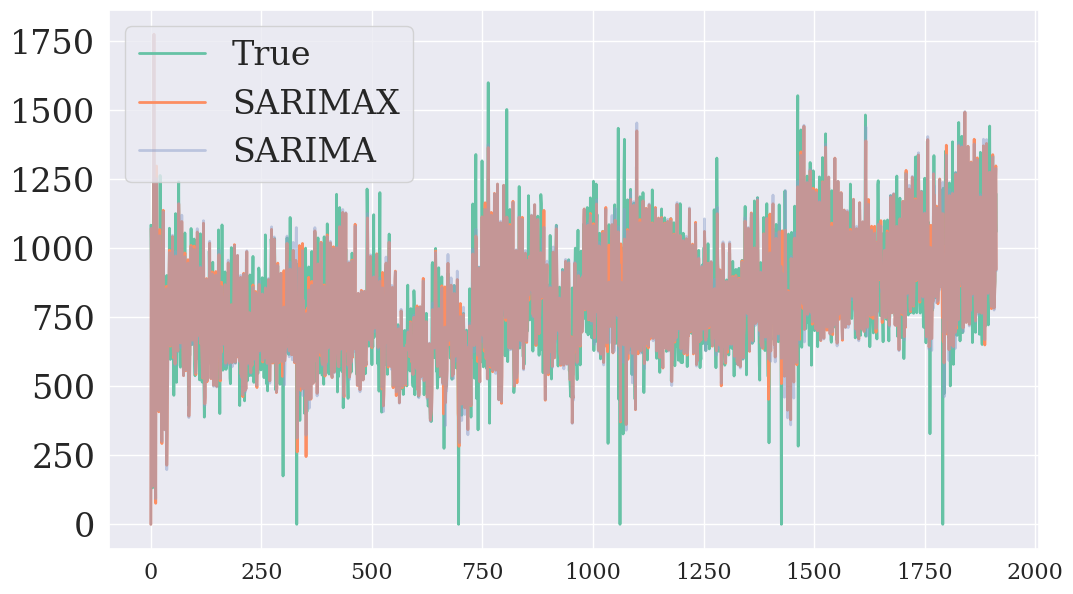

In [64]:
plt.plot(train_data.y.values, label='True')
plt.plot(sarimax2_res.predict().values, label='SARIMAX')
plt.plot(sarima_results.predict().values, label='SARIMA', alpha=0.5)

plt.legend()
plt.show()

- А теперь давайте сравним предсказания моделей двух классов.
- Каким тестом воспользуетесь?
- Какие у данного теста есть ограничения?
- Какую модель в итоге будете использовать?

Для начала посмотрим на метрики ранее изученных моделей

<u> Замечание: </u> Так как у моделей сем-ва SARIMAX предсказание в 1ый момент времени равно нулю (ибо порядок дифф-ния равен 1), то оценки качества получатся смещёнными.

Поэтому предлагается не рассматривать 1ый день при подсчёте метрик

In [116]:
future = model1.make_future_dataframe(periods=PRED_HORIZON)
forecast = model1.predict(future)
base_prophet_train = forecast['yhat'].values[1:len(train_data)]
base_prophet_tst = forecast['yhat'].values[len(train_data):]
base_prophet_ttl = forecast['yhat'].values[1:]

future = prophet_model.make_future_dataframe(periods=PRED_HORIZON)
forecast = prophet_model.predict(future)
prophet_train = forecast['yhat'].values[1:len(train_data)]
prophet_tst = forecast['yhat'].values[len(train_data):]
prophet_ttl = forecast['yhat'].values[1:]

arima_train = arima_model.predict().values[1:len(train_data)]
sarima_train = sarima_results.predict().values[1:len(train_data)]
sarimax_train = sarimax2_res.predict().values[1:len(train_data)]

arima_tst = arima_model.predict(start=len(train_data), end=len(data)-1).values
sarima_tst = sarima_results.predict(start=len(train_data), end=len(data)-1).values
sarimax_tst = sarimax2_res.predict(
    start=len(train_data),
    end=len(data)-1,
    exog=sarimax_holidays.iloc[len(train_data):, significant_holidays_ind+1]
).values

arima_ttl = list(arima_train) + list(arima_tst)
sarima_ttl = list(sarima_train) + list(sarima_tst)
sarimax_ttl = list(sarimax_train) + list(sarimax_tst)

y_train = train_data.y.values[1:]
y_tst = test_data.y.values
y_ttl = data.y.values[1:]

In [115]:
print('Base Prophet:', evaluate_prediction(y_train, base_prophet_train))
print('Prophet:', evaluate_prediction(y_train, prophet_train))
print('ARIMA:', evaluate_prediction(y_train, arima_train))
print('SARIMA:', evaluate_prediction(y_train, sarima_train))
print('SARIMAX:', evaluate_prediction(y_train, sarimax_train))

Base Prophet: {'rmse': 127.025, 'mae': 92.818, 'mase': 0.584, 'smape': 0.125, 'mdape': 0.094}
Prophet: {'rmse': 111.78, 'mae': 84.12, 'mase': 0.53, 'smape': 0.115, 'mdape': 0.087}
ARIMA: {'rmse': 131.292, 'mae': 94.129, 'mase': 0.593, 'smape': 0.126, 'mdape': 0.095}
SARIMA: {'rmse': 153.56, 'mae': 110.991, 'mase': 0.699, 'smape': 0.151, 'mdape': 0.11}
SARIMAX: {'rmse': 151.353, 'mae': 110.16, 'mase': 0.694, 'smape': 0.15, 'mdape': 0.108}


/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))


По всем метрикам Prophet тащит **на трейне**.  
Посмотрим, что происходит **на тесте**

In [117]:
print('Base Prophet:', evaluate_prediction(y_tst, base_prophet_tst))
print('Prophet:', evaluate_prediction(y_tst, prophet_tst))
print('ARIMA:', evaluate_prediction(y_tst, arima_tst))
print('SARIMA:', evaluate_prediction(y_tst, sarima_tst))
print('SARIMAX:', evaluate_prediction(y_tst, sarimax_tst))

Base Prophet: {'rmse': 107.45, 'mae': 86.241, 'mase': 0.549, 'smape': 0.086, 'mdape': 0.082}
Prophet: {'rmse': 115.941, 'mae': 92.45, 'mase': 0.588, 'smape': 0.092, 'mdape': 0.084}
ARIMA: {'rmse': 109.025, 'mae': 91.32, 'mase': 0.581, 'smape': 0.092, 'mdape': 0.087}
SARIMA: {'rmse': 127.908, 'mae': 104.843, 'mase': 0.667, 'smape': 0.109, 'mdape': 0.096}
SARIMAX: {'rmse': 132.328, 'mae': 108.575, 'mase': 0.691, 'smape': 0.114, 'mdape': 0.106}


Но на тестовой выборке внезапно оказывается, что базовый Prophet лучше улучшенного п по всем фронтам!!!  
Сказывается эффект переобучения.  

Далее ниже мы притворимся, что не видели рез-тов моделей на тестовой выборке.
Попробуем на основе train-а построить комбинацию моделей и сравнить качество полученного трансформера с базовым Prophet-ом

Давайте посмотрим, можем ли мы улучшить качество прогноза путём комбинирования предсказаний.

Для начала проведём тест на вложенность прогнозов

In [118]:
predictions = pd.DataFrame()
predictions['y'] = y_train
predictions['base_prophet'] = base_prophet_train
predictions['prophet'] = prophet_train
predictions['arima'] = arima_train
predictions['sarima'] = sarima_train
predictions['sarimax'] = sarimax_train

`BaseProphet` vs `Prophet`

In [119]:
formula = 'y ~ base_prophet + prophet'
results = ols(formula, predictions).fit()
hypotheses = '(base_prophet = 0), (prophet = 1)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (base_prophet = 0), (prophet = 1) testing results:  <F test: F=0.042638369702688646, p=0.9582587750587973, df_denom=1.91e+03, df_num=2>


Ожидаемо, прогноз базового Prophet вложен в прогноз улучшенного Prophet

`SARIMA` vs `SARIMAX`

In [120]:
formula = 'y ~ sarima + sarimax'
results = ols(formula, predictions).fit()
hypotheses = '(sarima = 0), (sarimax = 1)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (sarima = 0), (sarimax = 1) testing results:  <F test: F=117.5948630100229, p=6.894836950949995e-49, df_denom=1.91e+03, df_num=2>


In [121]:
formula = 'y ~ sarima + sarimax'
results = ols(formula, predictions).fit()
hypotheses = '(sarima = 1), (sarimax = 0)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (sarima = 1), (sarimax = 0) testing results:  <F test: F=149.08777673285402, p=6.870040351938755e-61, df_denom=1.91e+03, df_num=2>


А вот тут уже неожиданно: SARIMA не вложена в SARIMAX

`ARIMA` vs `SARIMA`

In [122]:
formula = 'y ~ arima + sarima'
results = ols(formula, predictions).fit()
hypotheses = '(arima = 0), (sarima = 1)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (arima = 0), (sarima = 1) testing results:  <F test: F=356.7654144591692, p=2.293210110551718e-132, df_denom=1.91e+03, df_num=2>


In [123]:
formula = 'y ~ arima + sarima'
results = ols(formula, predictions).fit()
hypotheses = '(arima = 1), (sarima = 0)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (arima = 1), (sarima = 0) testing results:  <F test: F=3.912040686984648, p=0.02016018358951786, df_denom=1.91e+03, df_num=2>


Вот тут возникает спорный момент.  
С учётом того, что на трейне ARIMA лучше, отбросим SARIMA из рассмотрения

`ARIMA` vs `SARIMAX`

In [124]:
formula = 'y ~ arima + sarimax'
results = ols(formula, predictions).fit()
hypotheses = '(arima = 0), (sarimax = 1)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (arima = 0), (sarimax = 1) testing results:  <F test: F=323.8821037216489, p=7.7358239821188e-122, df_denom=1.91e+03, df_num=2>


In [125]:
formula = 'y ~ arima + sarimax'
results = ols(formula, predictions).fit()
hypotheses = '(arima = 1), (sarimax = 0)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (arima = 1), (sarimax = 0) testing results:  <F test: F=7.3248721427110794, p=0.0006776298080111661, df_denom=1.91e+03, df_num=2>


SARIMAX и ARIMA не вложены друг в друга

`ARIMA` vs `Prophet`

In [126]:
formula = 'y ~ arima + prophet'
results = ols(formula, predictions).fit()
hypotheses = '(arima = 0), (prophet = 1)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (arima = 0), (prophet = 1) testing results:  <F test: F=10.238376726781025, p=3.7775279676030026e-05, df_denom=1.91e+03, df_num=2>


In [127]:
formula = 'y ~ arima + prophet'
results = ols(formula, predictions).fit()
hypotheses = '(arima = 1), (prophet = 0)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (arima = 1), (prophet = 0) testing results:  <F test: F=376.2466673202668, p=1.7663659969475078e-138, df_denom=1.91e+03, df_num=2>


Не удивительно, что ARIMA и Prophet не вложены друг в друга

`SARIMAX` vs `Prophet`

In [128]:
formula = 'y ~ sarimax + prophet'
results = ols(formula, predictions).fit()
hypotheses = '(sarimax = 0), (prophet = 1)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (sarimax = 0), (prophet = 1) testing results:  <F test: F=17.362802222295475, p=3.3666155457228866e-08, df_denom=1.91e+03, df_num=2>


In [129]:
formula = 'y ~ sarimax + prophet'
results = ols(formula, predictions).fit()
hypotheses = '(sarimax = 1), (prophet = 0)'
f_test = results.f_test(hypotheses)
print('Hypothesis {} testing results: '.format(hypotheses), f_test)

Hypothesis (sarimax = 1), (prophet = 0) testing results:  <F test: F=827.2857082126437, p=1.7971346161647853e-259, df_denom=1.91e+03, df_num=2>


**Вывод:**  
Итак, в итоге будем работать с моделями ARIMA, SARIMAX и улучшенным Prophet

1. Взвешивание с помощью линейной регрессии

In [138]:
formula = 'y ~ prophet + arima + sarimax'
results = ols(formula, predictions).fit()
lin_combo = results.predict()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     1448.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:25:36   Log-Likelihood:                -11714.
No. Observations:                1912   AIC:                         2.344e+04
Df Residuals:                    1908   BIC:                         2.346e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.6365     14.006     -1.188      0.235     -44.105      10.832
prophet        0.8749      0.032     27.421      0.000       0.812       0.937
arima          0.0322      0.049      0.654      0.513      -0.064       0.129
sarimax        0.1142      0.030      3.811      0.000       0.055       0.173
==============================================================================
Omnibus:                      107.316   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.913
Skew:                           0.103   Prob(JB):                     3.22e-88
Kurtosis:                       5.239   Cond. No.                     7.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2. Взвешиваем по ошибкам

In [137]:
rmse_prophet = evaluate_prediction(y_train, prophet_train)['rmse']
rmse_arima = evaluate_prediction(y_train, arima_train)['rmse']
rmse_sarimax = evaluate_prediction(y_train, sarimax_train)['rmse']

rmse_total = rmse_prophet + rmse_arima + rmse_sarimax

w_prophet = (rmse_arima + rmse_sarimax) / (rmse_total*2)
w_arima = (rmse_prophet + rmse_sarimax) / (rmse_total*2)
w_sarimax = (rmse_arima + rmse_prophet) / (rmse_total*2)

print('prophet weight: {}, arima weight: {}, sarimax weight: {}'.format(w_prophet, w_arima, w_sarimax))

rmse_combo = w_prophet*prophet_train + w_arima*arima_train + w_sarimax*sarimax_train

prophet weight: 0.35830005704506557, arima weight: 0.3335653166001141, sarimax weight: 0.3081346263548203


/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))


Сравниваем 4 модели

In [139]:
print('Prophet:', evaluate_prediction(y_train, prophet_train))
print('ARIMA:', evaluate_prediction(y_train, arima_train))
print('SARIMAX:', evaluate_prediction(y_train, sarimax_train))
print('LinReg Combo:', evaluate_prediction(y_train, lin_combo))
print('RMSEWeight Combo:', evaluate_prediction(y_train, rmse_combo))

Prophet: {'rmse': 111.78, 'mae': 84.12, 'mase': 0.53, 'smape': 0.115, 'mdape': 0.087}
ARIMA: {'rmse': 131.292, 'mae': 94.129, 'mase': 0.593, 'smape': 0.126, 'mdape': 0.095}
SARIMAX: {'rmse': 151.353, 'mae': 110.16, 'mase': 0.694, 'smape': 0.15, 'mdape': 0.108}
LinReg Combo: {'rmse': 110.764, 'mae': 83.207, 'mase': 0.524, 'smape': 0.114, 'mdape': 0.086}
RMSEWeight Combo: {'rmse': 119.191, 'mae': 88.017, 'mase': 0.554, 'smape': 0.12, 'mdape': 0.091}


/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))
/tmp/ipykernel_22529/24629914.py:36: RuntimeWarning: divide by zero encountered in divide
  mdape_pred = np.median(np.abs(target - pred) / np.abs(target))


Лучше себя на трейне показала лин.комбинация моделей Prophet, ARIMA и SARIMAX  

Посмотрим, что происходит на тесте

In [144]:
lin_combo_test = \
    results.params['Intercept'] + \
    results.params['prophet'] * prophet_tst + \
    results.params['arima'] * arima_tst + \
    results.params['sarimax'] * sarimax_tst

rmse_combo_test = \
    w_prophet * prophet_tst + \
    w_arima * arima_tst + \
    w_sarimax * sarimax_tst

print('Base Prophet:', evaluate_prediction(y_tst, base_prophet_tst))
print('ARIMA:', evaluate_prediction(y_tst, arima_tst))
print('LinReg Combo:', evaluate_prediction(y_tst, lin_combo_test))
print('RMSEWeight Combo:', evaluate_prediction(y_tst, rmse_combo_test))

Base Prophet: {'rmse': 107.45, 'mae': 86.241, 'mase': 0.549, 'smape': 0.086, 'mdape': 0.082}
ARIMA: {'rmse': 109.025, 'mae': 91.32, 'mase': 0.581, 'smape': 0.092, 'mdape': 0.087}
LinReg Combo: {'rmse': 114.546, 'mae': 93.097, 'mase': 0.592, 'smape': 0.093, 'mdape': 0.085}
RMSEWeight Combo: {'rmse': 114.515, 'mae': 95.339, 'mase': 0.607, 'smape': 0.097, 'mdape': 0.083}


**Неутешительный вывод**:  
Исходя из имеющихся данных, оптимальной моделью на трейне является ЛК Prophet, ARIMA и SARIMAX. Но на тесте оказывается, что обычный Prophet рвёт всех и вся. То есть все наши усилия были напрасны...  Поэтому стоит разбивать временной ряд на train-val-test, чтобы лучше оценивать предсказательные модели

**PS:**  
Хочется применить тест Диболда-Мариано на сравнение улучшенного Prophet-а и полученного мегатрона, но наш Prophet не является линейной моделью, отчего формально применить данный тест нельзя. Плюс ко всему, надо дополнительно определить вложенность прогнозов  


**Опционально**
- Можете посмотреть также на [Model Confidence Set](http://www.econ.upf.edu/~lugosi/hansen.pdf) (в [R](https://deliverypdf.ssrn.com/delivery.php?ID=721006122086126029008122096102104025121057026076017028009004070073075030011117018067003018063048018122018101098004022095096104106042011054015086010014019009066093071037037090073072109011022065022092067068097122090073100031093118107026068100105029083&EXT=pdf&INDEX=TRUE)) 
- Какое-то подобие на [Python](https://michael-gong.com/blogs/model-confidence-set/)

## №2.2 (60 баллов)

- Вы молодой, энергичный трейдер

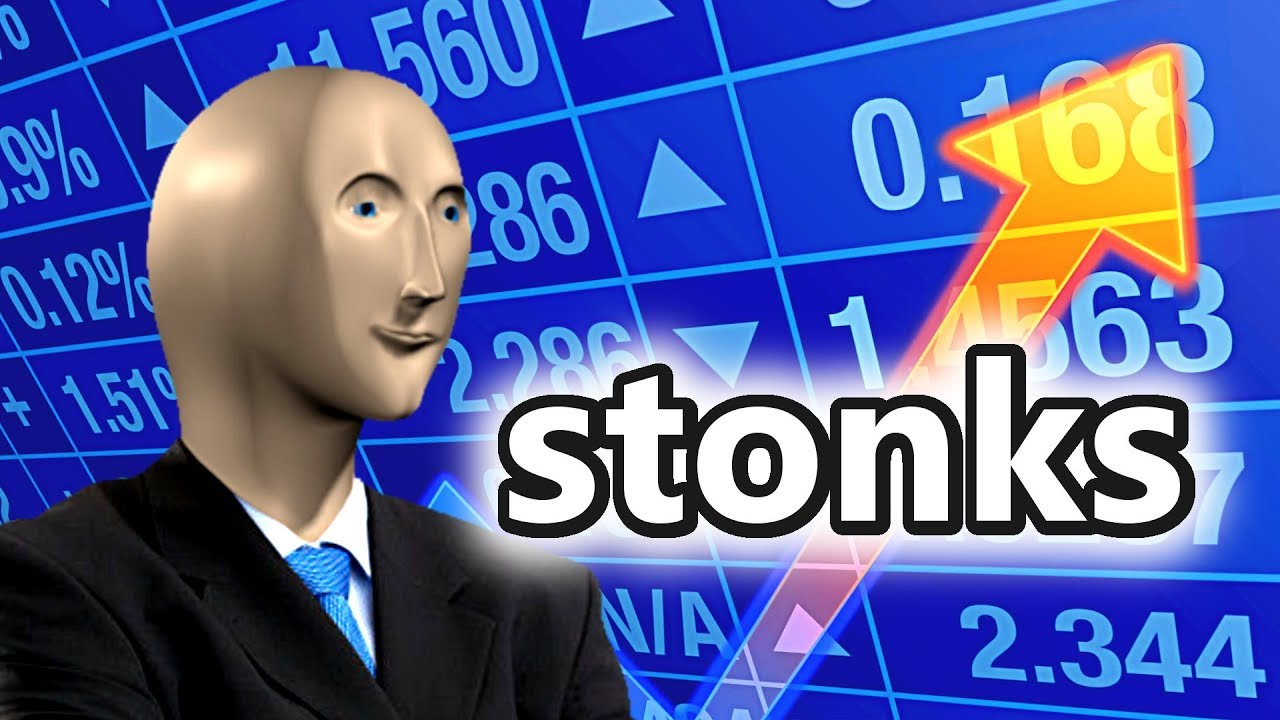

- Вы хотите применить свои знания моделей временных рядов для предсказания движения цен акций
- Для этого вы используете библиотеку `yfinance` (советую устанавливать с помощью `pip`, а не `conda install`), чтобы скачать котировки акций
- Вы должны выбрать одну акцию, которая есть в этом источнике и которая вам нравится
- После этого вы должны сделать все то же, самое, что делали в прошлом пункте - выбрать лучше модель, которая описывает данные
- Надеюсь, вы помните, что я говорил про цены и доходности, на занятии
- Однако вас волнует больше всего предсказательная способность модели, а не то, насколько хорошо она описывает данные
- В качестве аналога кросс валидации для моделей временных рядов используется бэктестирование с помощью скользящего или расширяющегося окна:
    1. Фиттим модель за период $\{0 ... t\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+1}$
    2. Если скользящее окно, то фиттим модель за период $\{1 ... t+1\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+2}$
       Если расширяющееся окно, то фиттим модель за период $\{0 ... t+1\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+2}$
    3. Делаем так столько раз, сколько считаем нужным. Обычно, в качестве out-of-sample выборки берется 20%-30% от выборки
    4. Например, у нас 1000 наблюдений. Считаем, что 30% наблюдений пойдут для out-of-sample предсказаний. Тогда:
        - На шаге 1 мы фиттим модель на 1-700 наблюдениях и делаем предсказание для 701 наблюдения
        - На шаге 2 (предположим, что у нас скользящее окно) мы фиттим модель на 2-701 наблюдениях и делаем предсказание для 702 наблюдения
        - Последним является предсказание для 1000-го наблюдения 
        - В итоге, имеем вектор предсказаний для 701-1000 наблюдений и их фактические значения, т.е. можем посчитать те или иные метрики качества (MSE, MAE, RMSE и т.п.)
        - Выбираем модель, у которой будет наилучшая метрика качества
- Однако, это не все. Наша цель использовать эту наилучшую модель для того, чтобы обыгрывать фондовый рынок. 
    - Например,
        - $t=0, P_0 = 100$
        - $t=1, P_1 = 110 \rightarrow r_1 = 0.1, \hat{r}_2 = 0.2 \rightarrow \text{ вы покупаете акцию и стоимость вашего портфеля } V = 110 \text{ равна цене акции}$
        - $t=2, P_2 = 105, r_2 = -0.045, \text{ т.е. вы ошиблись, и стоимость вашего портфеля упала} V = 105 \text{ вы продолжаете использовать модель и делаете новое предсказание } \hat{r}_3 = -0.01 \text{ предсказание получилось отрицательным. Что вы будете делать? Продадите акцию?}$
- Дам вам возможность шортить акции бесплатно. Почитать, что это такое, можно [тут](https://place.moex.com/useful/short-i-long-na-fondovom-rynke). Однако шорт - не обязателен, будет нормально, если вы будете просто продавать акцию и держать наличные деньги в портфеле.
- Собственно, вы должны подумать, как лучше использовать предсказания, чтобы по окончанию out-of-sample периода у вас был портфель с наибольшей стоимостью. Не забудь сравнить результат этой стратегии со стратегией, когда вы покупаете акцию в самый первый момент времени и держите ее до конца (buy & hold).
- Можете почитать [эту](https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/) статью в качестве пример (внимание! Там `R`)

- Результаты вашей работы потом будут показы CIO (Chef Investment Officer), который даст или не даст свое разрешение на распределение капитала на вашу модель+торговую стратегию
- CIO не хочет тратить много времени ~т.к. его очередь кидать карликов в мишень~, т.к. у него много других крупных задач и проектов, поэтому:
    - Ваша стратегия должна быть простой и понятной
    - Ваш выбор модели должен быть понятным и хорошо аргументированным
    - Ваша работа должна быть воспроизводима

- Ну, что же, давайте попробуем побыть [квантами](https://habr.com/ru/company/iticapital/blog/389979/)

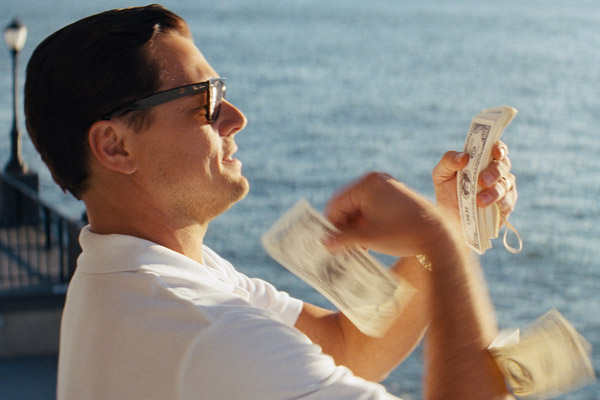

## №3 (20 баллов)*

- Это задание со звездочкой
- Баллы за это задание идут как дополнительные баллы
- Общий балл за это домашнее задание не может превышать 100 баллов
- Например, если за предыдущие 2 задания было набрано 100 баллов и за это задание набрано 20 баллов, то итоговый балл будет 100 баллов. Если же за предыдущие 2 задания было набрано 90 баллов и за это задание набрано 20 баллов, то итоговый балл все равно будет 100 баллов

- В самом первом домашнем задании вы рассматрели такой метод как Difference in Difference (DiD)
- Давайте посмотрим внимательнее на него, а также на CUPED (у вас он был на других курсах), и на SARIMAX

In [48]:
df = pd.read_csv('HW_004_002.csv')

In [49]:
df.head()

i  ad_campaign  revenue0  revenue1
0  1            0  5.315635  8.359304
1  2            1  2.977799  7.751485
2  3            0  4.693796  9.025253
3  4            0  5.827975  8.540667
4  5            0  5.230095  8.910165

- У нас с вами есть информация по 100 пользователям.
- `revenue0` - выручка до начала эксперимента
- `revenue1` - выручка после начала эксперимента
- `ad_campaign` - был ли пользователь в целевой группе

In [20]:
# Попробуйте воспользоваться методом DiD, который вы использовали в первой ДЗ
# Для начала вам стоит вспомнить, как выглядели данные в той первой ДЗ. Рекомендую почитать про pd.wide_to_long()


In [ ]:
# Давайте попробуем зафиттить простую DiD модельку


- Когда вы используется стандартную линейную регрессию из statsmodels у вас предполагается, что наблюдения независимы
- Но мы с вами знаем, что в данном случае у вас для индивидума i есть два наблюдения: до и после эксперимента
- Логично попробовать кластеризовать их по i, чтобы уменьшить дисперсию
- Почитайте про кластеризацию вариационно-ковариационной матрицы с помощью [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html)
- Что можете сказать про стандартные ошибки оценок коэффициентов?

- Чем равен эффект? Значим ли он?

In [17]:
# А теперь попробуйте воспользоваться CUPED


- Что у вас получилось?
- Отличается ли это от того, что у вас получилось ранее?

- Прежде чем вы продолжите, давайте я немного расскажу про все эти замечательные классы моделей SARIMAX
- Вы уже знаете общую теорию про SARIMA. В целом, этого вам достаточно. Буква `X` означает, что это модель с внешними регрессорами (eXternal regressors). 
- В качестве внешних регрессоров может быть все, что угодно
- Поэтому, когда вы видите, какую нибудь MA-X модель (хотя я сомневаюсь, что кто-то такое использует), это просто означает простую MA модель с внешними регрессорами

In [19]:
# А теперь попробуйте зафиттить AR-X модель. Я напомню, что revenue1 это значение после эксперимента, а revenue0 - до него


- Что у вас получилось?
- Отличается ли это от того, что у вас получилось ранее?

- Небольшой спойлер. У вас должны были получится более менее одинаковые коэффициенты
- А давайте посмотрим с новым набором данных

In [65]:
df_new = pd.read_csv('HW_004_003.csv')

In [66]:
df_new.head()

i  ad_campaign  revenue0  revenue1
0  1            0  5.315635  8.359304
1  2            1  3.977799  8.751485
2  3            0  4.693796  9.025253
3  4            0  5.827975  8.540667
4  5            0  5.230095  8.910165

- Проделайте все то же самое, что и ранее
- Что изменилось?
- В чем разница между старыми данными и этими?